<a href="https://colab.research.google.com/github/nadirawijaya/Skripsi/blob/main/Copy_of_Skripsi_Nadira_terbaru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <h1><b>SKRIPSI</b></h1>
  <h2><b>Pengaruh Seleksi Fitur IGWO terhadap Kinerja Random Forest, CatBoost, dan XGBoost<br>untuk Klasifikasi Penyakit Monkeypox Berdasarkan Gejala</b></h2>


  <br><br>
  <b>Diajukan oleh:</b><br>
  Nadira Putri Wijaya<br>
  2106635190<br>
  <a href="mailto:nadira.putri11@ui.ac.id">nadira.putri11@ui.ac.id</a>
  <br><br>

  <b>Dosen Pembimbing:</b><br>
  Dra. Bevina Desjwiandra Handari, M.Sc., Ph.D.
  <br><br><br>

  <b>Program Studi Sarjana Matematika</b><br>
  Departemen Matematika FMIPA Universitas Indonesia<br>
  Depok, Desember 2025
</center>


In [ ]:
# =============================================================================
# STEP 1: INISIALISASI PIPELINE & MANAJEMEN PUSTAKA
# =============================================================================

# =============================================================================
# STEP 1A: INSTALASI PUSTAKA YANG DIBUTUHKAN
# =============================================================================
import sys

# Cek apakah kode dijalankan di Google Colab untuk instalasi otomatis
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    print("📦 Lingkungan Google Colab terdeteksi. Menginstal paket yang dibutuhkan...")
    # Instalasi dalam mode senyap (-q) untuk output yang bersih
    !pip install pandas numpy matplotlib seaborn scikit-learn chardet catboost xgboost -q
    print("✅ Paket instalasi selesai!")
else:
    print("📘 Menjalankan di lingkungan lokal. Pastikan semua paket sudah terinstal.")

# =============================================================================
# STEP 1B: INISIALISASI PIPELINE & MANAJEMEN PUSTAKA
# =============================================================================

# === 1.1 MANAJEMEN PUSTAKA & SISTEM ===
import warnings
import sys
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet

from IPython.display import display, HTML

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier # Sekarang ini tidak akan error

# Mengelola peringatan agar output lebih bersih
warnings.filterwarnings('ignore')

# === 1.2 HEADER & PENGECEKAN LINGKUNGAN ===
print("🚀 Menginisialisasi Pipeline Preprocessing Monkeypox...")
print("="*80)

# Cek lagi untuk memastikan modul files diimpor jika di Colab
if 'google.colab' in sys.modules:
    from google.colab import files

print("\n📚 Semua pustaka berhasil diimpor.")

# === 1.3 KONFIGURASI VISUALISASI & DISPLAY ===
plt.style.use('seaborn-v0_8-whitegrid')  # Gaya plot modern & konsisten
sns.set_palette("viridis")               # Palet warna default yang menarik
pd.set_option('display.max_columns', 50) # Tampilkan hingga 50 kolom di output
pd.set_option('display.width', 120)      # Lebar tampilan output Pandas

print("🎨 Pengaturan visualisasi dan display telah diterapkan.")
print("="*80)
print("✅ STEP 1 SELESAI: Pipeline siap untuk memuat data.")
print("="*80)

📦 Lingkungan Google Colab terdeteksi. Menginstal paket yang dibutuhkan...
✅ Paket instalasi selesai!
🚀 Menginisialisasi Pipeline Preprocessing Monkeypox...

📚 Semua pustaka berhasil diimpor.
🎨 Pengaturan visualisasi dan display telah diterapkan.
✅ STEP 1 SELESAI: Pipeline siap untuk memuat data.


# 📝 Penjelasan STEP 2: Load, Clean, Explore, & Separate Data

**Tujuan Step 2:**  
Step ini berfokus pada **memuat dataset, membersihkan data, melakukan eksplorasi awal, dan memisahkan fitur dengan target**. Langkah ini penting karena sebelum membangun model machine learning, kita perlu memahami struktur dan kualitas data secara menyeluruh.

---

## Rincian proses di Step 2:

### 1️⃣ Load Data
- Menggunakan kelas `EnhancedCSVLoader` untuk membaca file CSV dengan strategi fallback jika terjadi error.
- Deteksi otomatis encoding dan separator agar data terbaca dengan benar.
- **Kenapa penting:** Dataset yang gagal terbaca akan menghentikan seluruh pipeline, jadi perlu metode yang robust.

### 2️⃣ Clean Data
- Membersihkan nama kolom agar konsisten, menghapus karakter aneh, mengganti spasi dengan underscore.
- Menghapus duplikat agar model tidak bias terhadap data yang berulang.
- **Kenapa penting:** Data yang bersih memudahkan analisis dan preprocessing, serta meningkatkan performa model.

### 3️⃣ Explore Data (EDA)
- Analisis struktur dataset: jumlah baris/kolom, missing values, tipe data, distribusi target.
- Identifikasi kolom leaky atau ID-like yang tidak relevan untuk fitur.
- Visualisasi distribusi target untuk memahami keseimbangan kelas.
- **Kenapa penting:** Eksplorasi membantu mengenali masalah kualitas data, outlier, dan distribusi kelas sebelum modeling.

### 4️⃣ Separate Features & Target
- Memisahkan kolom target (`y`) dari fitur (`X`).
- Menghapus kolom yang tidak relevan atau bersifat leaky.
- **Kenapa penting:** Model machine learning membutuhkan input `X` dan output `y` yang jelas.

---

**Kesimpulan:**  
Step 2 memastikan dataset **bersih, valid, dan siap untuk tahap preprocessing selanjutnya**, sehingga proses training model lebih efisien dan hasilnya lebih andal. Tanpa step ini, model bisa belajar dari data yang salah atau tidak lengkap, menghasilkan prediksi yang tidak akurat.


🚀 Memulai Pipeline Data Loading & Exploration Monkeypox...
📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁
ENHANCED FILE UPLOAD & COMPREHENSIVE EXPLORATION
📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁📁

📤 Silakan upload CSV Anda...


Saving MonkeyPox Dataset Skripsi.csv to MonkeyPox Dataset Skripsi (7).csv

✅ File 'MonkeyPox Dataset Skripsi (7).csv' berhasil diupload!
🔄 Loading CSV dengan strategi cerdas untuk 'MonkeyPox Dataset Skripsi (7).csv'...
   - Encoding terdeteksi: utf-8 (confidence: 93.8%)
   - Separator digunakan: ','
   - Mencoba strategi: Primary (,, utf-8)...
✅ Berhasil load dengan 'Primary (,, utf-8)'
📊 Bentuk awal: 500 baris × 50 kolom

🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍
COMPREHENSIVE DATA EXPLORATION & DIAGNOSTICS
🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍🔍

🧹 1. Standardizing Column Names
----------------------------------------
   ✅ Nama kolom telah dibersihkan dan distandarisasi.

🆔 2. Removing Non-Predictive ID Columns (Crucial Fix)
----------------------------------------
   - Dihapus 1 kolom ID: ['id']

🛡️ 3. Duplicate Row Detection & Removal (After ID Removal)
----------------------------------------
   ✅ Tidak ada baris duplikat yang terdeteksi.

🌡

,diagnosing
diagnosing,1.000000
complications_of_illness,0.927388
diagnosed_disease,0.893633
monkeypox_viral_dna_detected_in_nose_or_throat_swab,0.882169
conjunctivitis,0.830055
sexually_transmitted_infections,0.812176
complications_of_treatment,0.799681
creatinine_level_mgdl_normal_adult_range__15_,0.751812
monkeypox_viral_dna_detected_in_blood,0.750842
blood_urea_nitrogen_level_mgdl_normal_adult_range__1020,0.721720


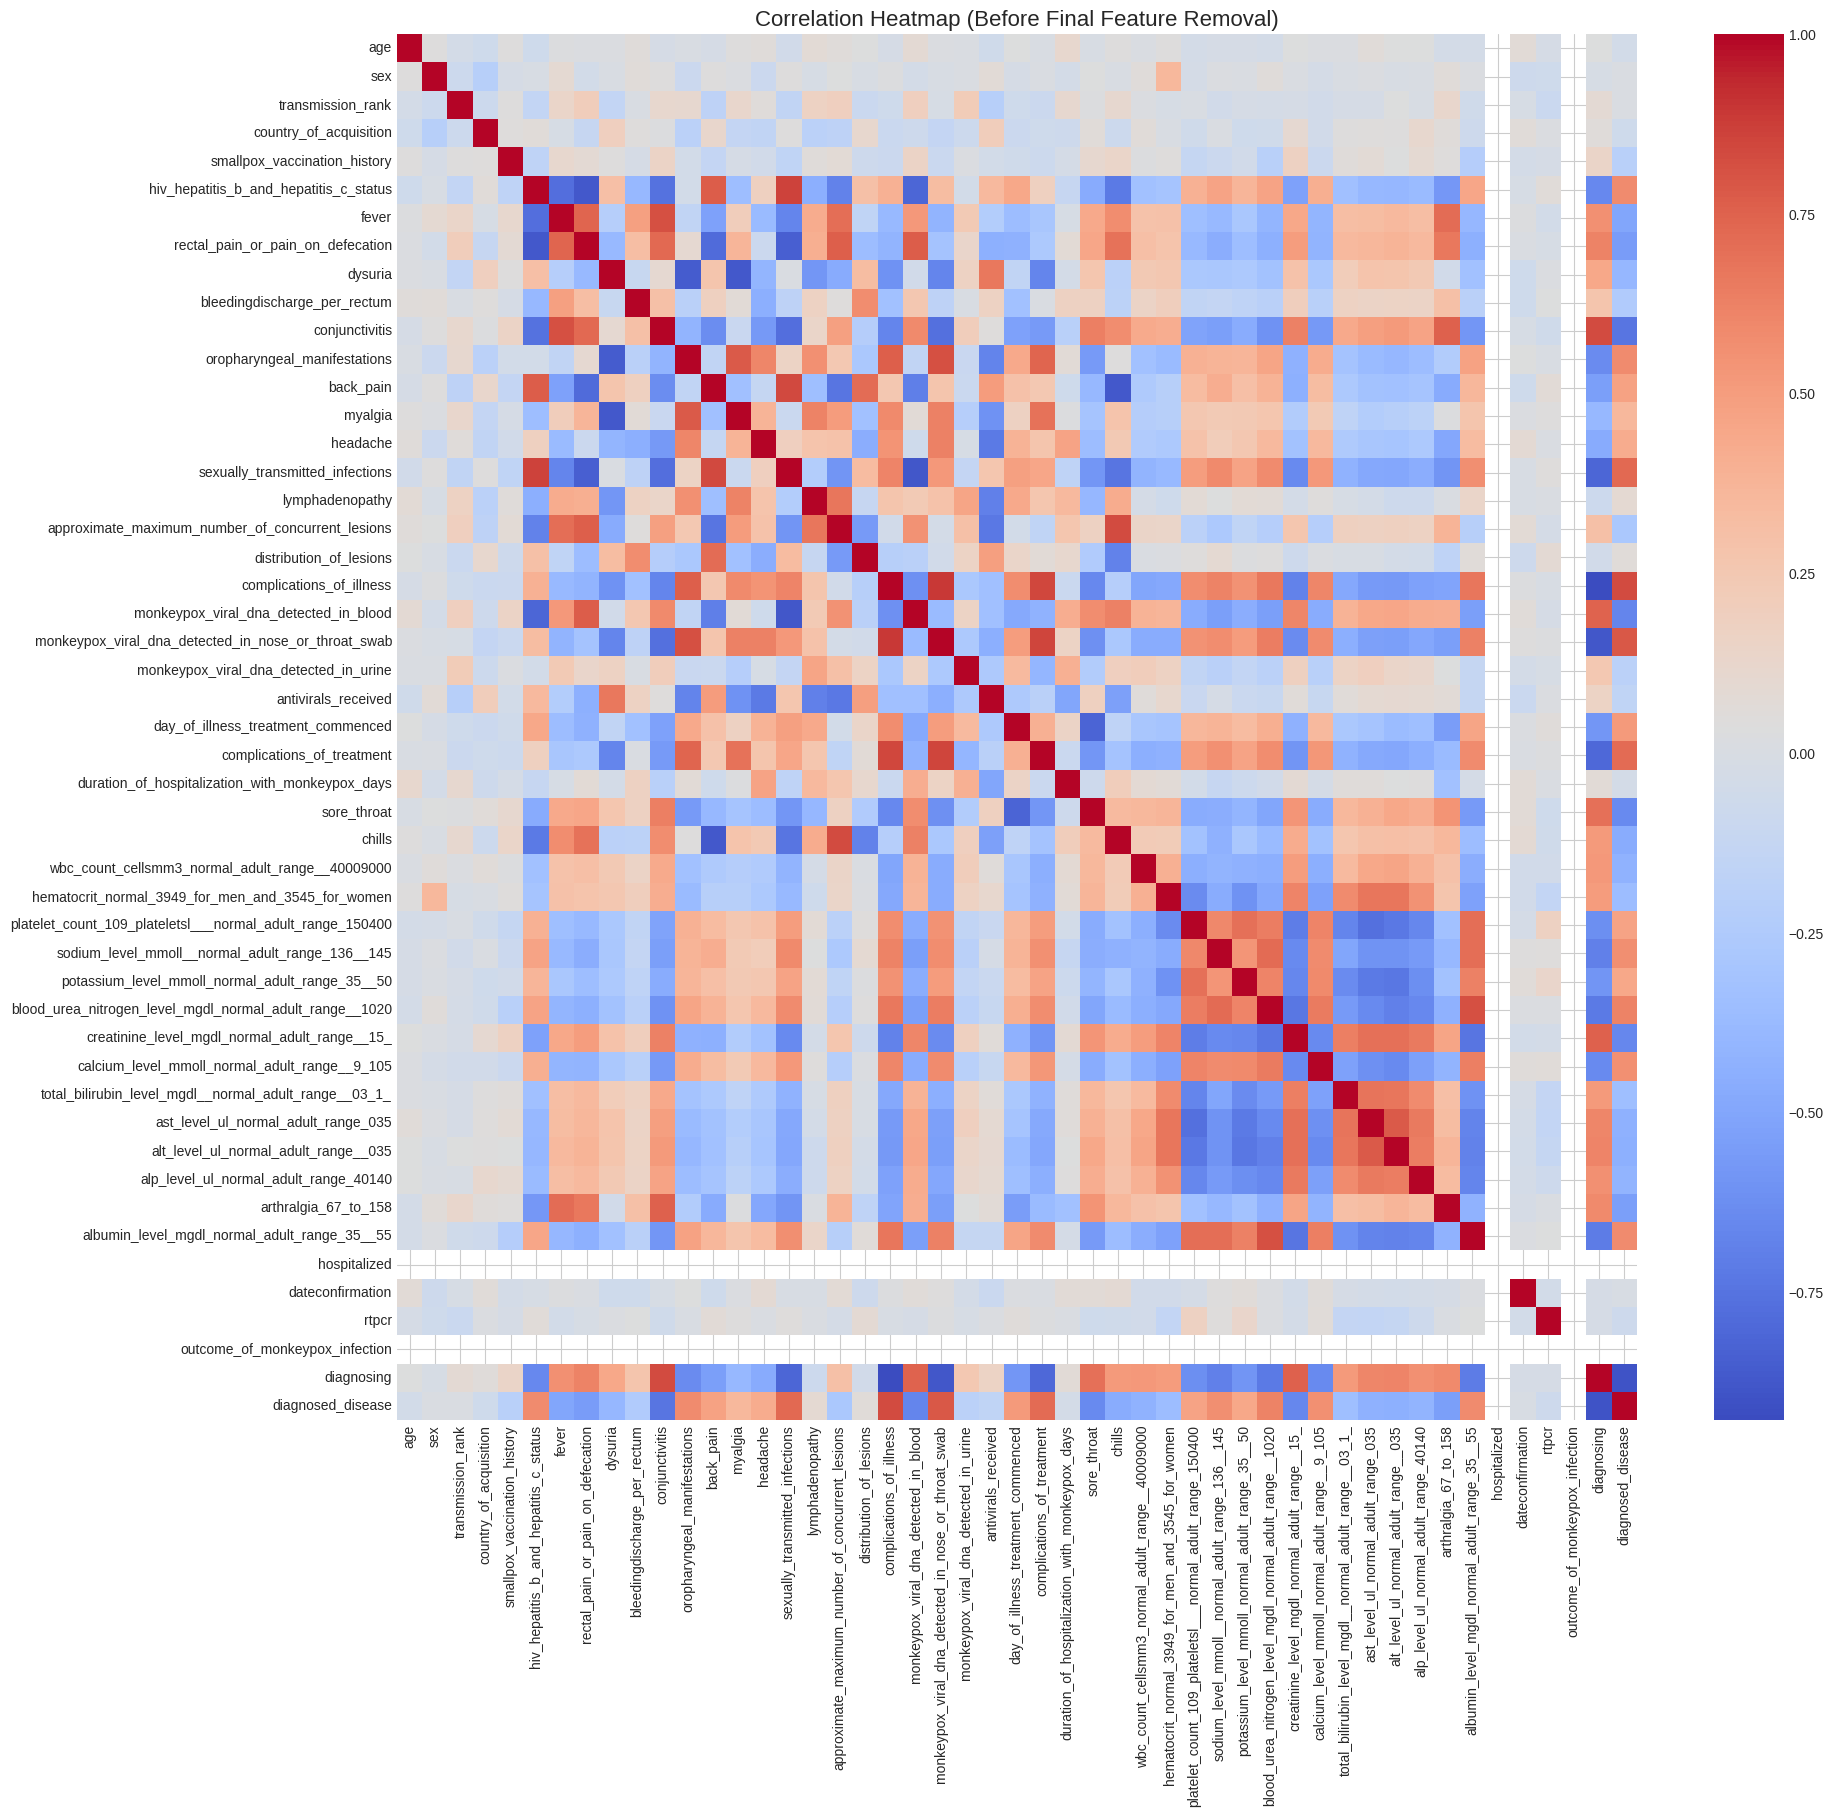


🔥 5. Removing Leaky & High-Cardinality Text Features
------------------------------------------------------------
📋 Laporan Penghapusan Fitur:

   - 💧 Leaky Feature:
     • Menghapus 'outcome_of_monkeypox_infection'
     • Menghapus 'duration_of_hospitalization_with_monkeypox_days'
     • Menghapus 'monkeypox_viral_dna_detected_in_blood'
     • Menghapus 'monkeypox_viral_dna_detected_in_nose_or_throat_swab'
     • Menghapus 'monkeypox_viral_dna_detected_in_urine'
     • Menghapus 'diagnosed_disease'

   - 📝 Teks Variasi Tinggi:
     • Menghapus 'distribution_of_lesions'
     • Menghapus 'complications_of_illness'
     • Menghapus 'antivirals_received'
     • Menghapus 'complications_of_treatment'
     • Menghapus 'sexually_transmitted_infections'
------------------------------------------------------------
   ✅ Total 11 kolom telah dihapus.
   - Jumlah kolom tersisa: 38

📊 6. General Dataset Overview (After All Cleaning)
----------------------------------------


,Metric,Value
0,Total Rows,500
1,Total Columns,38
2,Memory Usage (MB),0.62
3,Missing Values,0
4,Duplicate Rows,0
5,Data Density,100.0%



📋 5 baris pertama dataset:


,age,sex,transmission_rank,country_of_acquisition,smallpox_vaccination_history,hiv_hepatitis_b_and_hepatitis_c_status,fever,rectal_pain_or_pain_on_defecation,dysuria,bleedingdischarge_per_rectum,conjunctivitis,oropharyngeal_manifestations,back_pain,myalgia,headache,lymphadenopathy,approximate_maximum_number_of_concurrent_lesions,day_of_illness_treatment_commenced,sore_throat,chills,wbc_count_cellsmm3_normal_adult_range__40009000,hematocrit_normal_3949_for_men_and_3545_for_women,platelet_count_109_plateletsl___normal_adult_range_150400,sodium_level_mmoll__normal_adult_range_136__145,potassium_level_mmoll_normal_adult_range_35__50,blood_urea_nitrogen_level_mgdl_normal_adult_range__1020,creatinine_level_mgdl_normal_adult_range__15_,calcium_level_mmoll_normal_adult_range__9_105,total_bilirubin_level_mgdl__normal_adult_range__03_1_,ast_level_ul_normal_adult_range_035,alt_level_ul_normal_adult_range__035,alp_level_ul_normal_adult_range_40140,arthralgia_67_to_158,albumin_level_mgdl_normal_adult_range_35__55,hospitalized,dateconfirmation,rtpcr,diagnosing
0,49,female,isolated,Nigeria,none,negative,yes (2days),yes,none,none,yes,tonsillar erythema,none,yes,yes,yes,150,7,yes,yes,22135,48,109,129,2.4,8.4,2.2,8.2,1.0,41,37,147,10.0,2.5,yes,5/6/2022,yes,positive
1,52,female,index,Spain,none,positive,yes,none,yes,none,yes,abscess,yes,none,none,none,40,7,yes,none,14026,48,138,131,1.9,8.4,1.8,7.3,1.1,42,37,145,9.8,1.9,yes,8/31/2022,no,positive
2,76,male,Index,Nigeria,none,negative,yes (4days),yes,none,yes,yes,pustules,yes,yes,none,yes,100,6,yes,none,26742,56,131,117,2.9,8.3,1.5,6.1,1.0,38,42,149,11.0,2.8,yes,5/12/2022,yes,positive
3,42,female,Secondary,Nigeria,MVA six days post-exposure or 12 days pre-illness,positive,Coryzal illness (1 day),none,yes,none,none,oedema,yes,none,yes,none,32,7,yes,none,24688,49,115,126,2.4,7.8,1.7,8.3,1.6,43,41,143,6.6,2.0,yes,8/13/2022,yes,positive
4,67,male,Isolated,Nigeria,none,negative,yes (2days),none,yes,none,yes,abscess,none,yes,none,yes,100,7,yes,yes,20346,52,144,126,3.3,7.9,1.8,7.7,1.4,43,38,143,7.0,2.7,yes,5/15/2022,no,positive



📋 7. Detailed Column-by-Column Analysis
----------------------------------------


,Column Name,Data Type,Null %,Unique Values,Details (Min/Max),Details (Top Value)
No,,,,,,
1,age,int64,0.0%,79,2.00 / 80.00,NaN
2,sex,object,0.0%,2,NaN,'male ...'
3,transmission_rank,object,0.0%,7,NaN,'isolated...'
4,country_of_acquisition,object,0.0%,37,NaN,'Nigeria...'
5,smallpox_vaccination_history,object,0.0%,3,NaN,'none ...'
6,hiv_hepatitis_b_and_hepatitis_c_status,object,0.0%,3,NaN,'positive...'
7,fever,object,0.0%,5,NaN,'none...'
8,rectal_pain_or_pain_on_defecation,object,0.0%,2,NaN,'none...'
9,dysuria,object,0.0%,2,NaN,'none...'



🚦 8. Data Quality Assessment
----------------------------------------
   Potensi Masalah Ditemukan:
     - ⚠️ Constant Value Columns: ['hospitalized']

🎯 9. Target Variable Analysis
----------------------------------------
   ✅ Target ditetapkan: 'diagnosing'

   📊 Distribusi Target:


,Class,Count,Percentage
0,positive,297,59.4%
1,negative,203,40.6%



   ⚖️ Class Balance: ✅ Reasonably Balanced (Minority/Majority Ratio: 0.68)


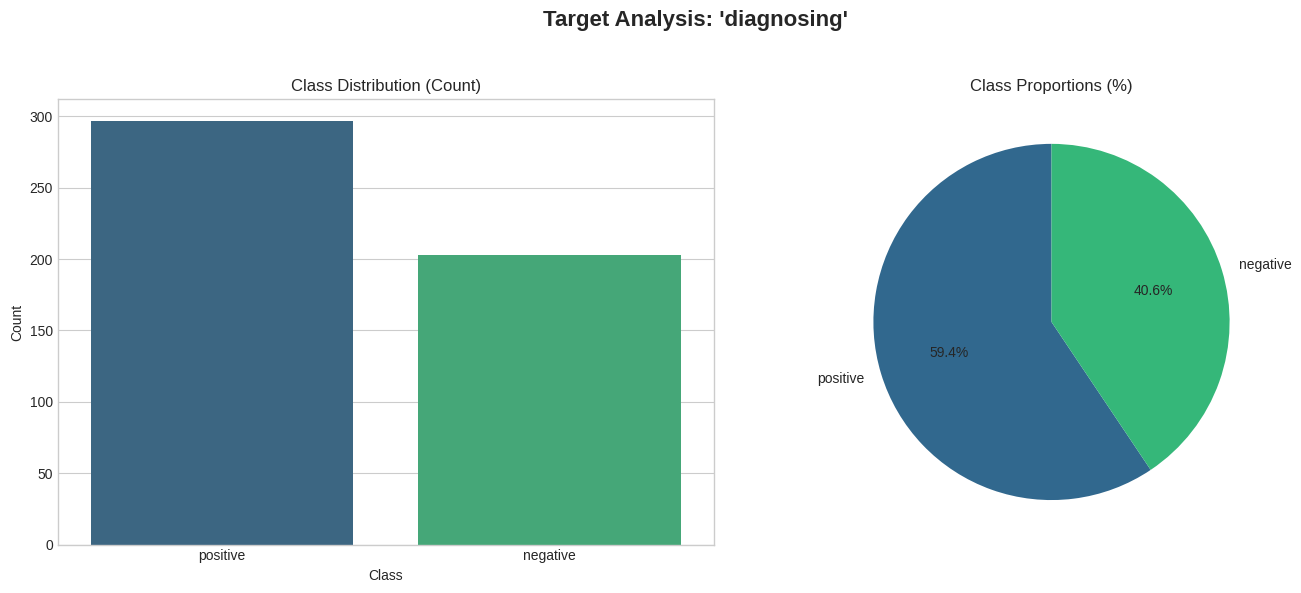


⚙️ 10. Memory & Performance Diagnostics
----------------------------------------
   - Total Memory Usage: 0.62 MB

   Top 5 kolom dengan penggunaan memory terbesar:
     • smallpox_vaccination_history: 0.032 MB (5.3%)
     • oropharyngeal_manifestations: 0.029 MB (4.7%)
     • dateconfirmation: 0.028 MB (4.5%)
     • hiv_hepatitis_b_and_hepatitis_c_status: 0.027 MB (4.5%)
     • diagnosing: 0.027 MB (4.4%)

🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
FINALIZING STEP 2: SEPARATING FEATURES (X) AND TARGET (y)
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
   - Target (y) ditetapkan sebagai: 'diagnosing'

   Pemisahan data selesai:
   - X_initial shape: (500, 37)
   - y_initial shape: (500,)

✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
STEP 2: DATA LOADING, CLEANING, & EXPLORATION COMPLETED SUCCESSFULLY!
✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅
📋 Final Summary:
   - Final Shape (after cleaning): 500 rows × 38 columns
   - Dataset telah dipisahkan menjadi `X_in

In [ ]:
# =============================================================================
# STEP 2: LOAD, CLEAN, EXPLORE, & SEPARATE DATA (FINAL REVISION WITH LOGIC FIX)
# =============================================================================
import pandas as pd
import numpy as np
import sys
import re
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.preprocessing import LabelEncoder

# --- Pastikan modul Colab dikenali ---
if 'google.colab' in sys.modules:
    from google.colab import files

# === 2.1 ENHANCED CSV LOADER CLASS (Tidak ada perubahan) ===
class EnhancedCSVLoader:
    """Loader CSV yang tahan error dan mendukung berbagai strategi fallback"""
    def _validate_dataframe(self, df):
        return df is not None and not df.empty and df.shape[1] > 1
    def load_csv(self, file_path):
        print(f"🔄 Loading CSV dengan strategi cerdas untuk '{file_path}'...")
        try:
            with open(file_path, 'rb') as f:
                rawdata = f.read(20000); result = chardet.detect(rawdata)
                encoding = result['encoding']; confidence = result['confidence']
                print(f"   - Encoding terdeteksi: {encoding} (confidence: {confidence:.1%})")
        except Exception:
            encoding = 'utf-8'; print("   - Warning: Gagal mendeteksi encoding, default ke utf-8.")
        try:
            with pd.read_csv(file_path, sep=None, iterator=True, engine='python', encoding=encoding) as reader:
                df_sample = reader.get_chunk(5)
                if len(df_sample.columns) == 1 and ',' in df_sample.columns[0]: separator = ','
                elif len(df_sample.columns) > 1: separator = ','
                else: separator=';'
        except: separator = ','
        print(f"   - Separator digunakan: '{separator}'")
        strategies = [
            {"name": f"Primary ({separator}, {encoding})", "params": {"sep": separator, "encoding": encoding}},
            {"name": "Fallback comma", "params": {"sep": ',', "encoding": 'utf-8'}},
            {"name": "Fallback semicolon", "params": {"sep": ';', "encoding": 'utf-8'}},
        ]
        for strategy in strategies:
            try:
                print(f"   - Mencoba strategi: {strategy['name']}...")
                df = pd.read_csv(file_path, **strategy['params'])
                if self._validate_dataframe(df):
                    print(f"✅ Berhasil load dengan '{strategy['name']}'"); print(f"📊 Bentuk awal: {df.shape[0]} baris × {df.shape[1]} kolom")
                    return df
            except Exception: continue
        print("❌ Semua strategi gagal. Periksa format file."); return None

# === 2.2 COMPREHENSIVE DATA EXPLORER CLASS (DIREVISI DENGAN URUTAN LOGIKA YANG BENAR) ===
class ComprehensiveDataExplorer:
    """
    Pipeline EDA lengkap dengan urutan logika yang sudah diperbaiki untuk mencegah leakage.
    """
    def __init__(self, df):
        self.df = df

    def run_exploration(self):
        print("\n" + "🔍"*60); print("COMPREHENSIVE DATA EXPLORATION & DIAGNOSTICS"); print("🔍"*60)

        # --- URUTAN LOGIKA BARU YANG SUDAH DIPERBAIKI ---
        self.df = self._clean_column_names()                           # 1. Bersihkan nama kolom
        self.df = self._remove_non_predictive_ids()                    # 2. [FIX] Hapus kolom ID terlebih dahulu
        self.df = self._handle_duplicates()                            # 3. [FIX] Baru cari dan hapus baris duplikat
        self._analyze_correlation_matrix()                             # 4. Analisis korelasi sebagai justifikasi
        self.df = self._remove_leaky_and_text_features()               # 5. Hapus fitur bocor & teks bebas
        self._display_overview()                                       # 6. Tampilkan overview (setelah semua pembersihan)
        self._analyze_columns_detailed()                               # 7. Analisis tiap kolom
        self._assess_data_quality()                                    # 8. Penilaian kualitas data
        self._identify_and_analyze_target()                            # 9. Analisis target variable
        self._performance_diagnostics()                                # 10. Cek memory

        return self.df

    def _clean_column_names(self):
        print("\n🧹 1. Standardizing Column Names"); print("-" * 40)
        original_columns = self.df.columns.tolist(); cleaned_columns = []
        for col in original_columns:
            col = col.replace('\n', ' ').strip().lower(); col = re.sub(r'\s+', ' ', col); col = re.sub(r'[^a-z0-9\s]', '', col); col = col.replace(' ', '_'); cleaned_columns.append(col)
        self.df.columns = cleaned_columns; print("   ✅ Nama kolom telah dibersihkan dan distandarisasi."); return self.df

    # --- FUNGSI BARU UNTUK MENGHAPUS ID DI AWAL ---
    def _remove_non_predictive_ids(self):
        print("\n🆔 2. Removing Non-Predictive ID Columns (Crucial Fix)")
        print("-" * 40)
        id_columns_to_drop = ['id', 'patient_id']
        existing_ids = [col for col in id_columns_to_drop if col in self.df.columns]
        if existing_ids:
            self.df.drop(columns=existing_ids, inplace=True)
            print(f"   - Dihapus {len(existing_ids)} kolom ID: {existing_ids}")
        else:
            print("   - Tidak ada kolom ID yang perlu dihapus.")
        return self.df

    def _handle_duplicates(self):
        print("\n🛡️ 3. Duplicate Row Detection & Removal (After ID Removal)")
        print("-" * 40)
        exact_duplicates_count = self.df.duplicated().sum(); original_count = len(self.df)
        if exact_duplicates_count > 0:
            print(f"   - Ditemukan {exact_duplicates_count} baris duplikat (setelah ID dihapus).")
            self.df = self.df.drop_duplicates(keep='first').reset_index(drop=True)
            final_count = len(self.df); removed_count = original_count - final_count
            print(f"   - Dihapus {removed_count} baris duplikat. Dataset dari {original_count} → {final_count}")
            self._visualize_duplicate_removal(original_count, final_count)
        else:
            print("   ✅ Tidak ada baris duplikat yang terdeteksi.")
        return self.df

    def _analyze_correlation_matrix(self):
        print("\n🌡️ 4. Correlation Matrix Analysis"); print("-" * 60)
        df_corr = self.df.copy(); le = LabelEncoder()
        for col in df_corr.select_dtypes(include=['object', 'category']).columns: df_corr[col] = le.fit_transform(df_corr[col])
        if 'diagnosing' not in df_corr.columns: print("   - ⚠️ Peringatan: Kolom target 'diagnosing' tidak ditemukan."); return
        corr_matrix = df_corr.corr(); print("   - Korelasi setiap fitur terhadap target 'diagnosing':")
        corr_target = corr_matrix['diagnosing'].abs().sort_values(ascending=False)
        display(corr_target.to_frame().style.background_gradient(cmap='Reds'))
        plt.figure(figsize=(20, 18)); sns.heatmap(corr_matrix, cmap='coolwarm'); plt.title('Correlation Heatmap (Before Final Feature Removal)', fontsize=16); plt.show()

    def _remove_leaky_and_text_features(self):
        print("\n🔥 5. Removing Leaky & High-Cardinality Text Features")
        print("-" * 60)
        removal_plan = {
            "💧 Leaky Feature": ['outcome_of_monkeypox_infection', 'duration_of_hospitalization_with_monkeypox_days',
                                 'monkeypox_viral_dna_detected_in_blood', 'monkeypox_viral_dna_detected_in_nose_or_throat_swab',
                                 'monkeypox_viral_dna_detected_in_urine', 'diagnosed_disease', 'rt_pcr', 'date_confirmation'],
            "📝 Teks Variasi Tinggi": ['distribution_of_lesions', 'complications_of_illness', 'antivirals_received',
                                     'complications_of_treatment', 'sexually_transmitted_infections']
        }
        total_removed_count = 0
        print("📋 Laporan Penghapusan Fitur:")
        for reason, columns in removal_plan.items():
            cols_to_drop_existing = [col for col in columns if col in self.df.columns]
            if cols_to_drop_existing:
                print(f"\n   - {reason}:"); [print(f"     • Menghapus '{col}'") for col in cols_to_drop_existing]
                self.df.drop(columns=cols_to_drop_existing, inplace=True); total_removed_count += len(cols_to_drop_existing)
        if total_removed_count > 0:
            print("-" * 60); print(f"   ✅ Total {total_removed_count} kolom telah dihapus."); print(f"   - Jumlah kolom tersisa: {self.df.shape[1]}")
        else: print("   ✅ Tidak ada kolom yang perlu dihapus dari rencana.")
        return self.df

    # ... (Semua fungsi lain _visualize_duplicate_removal, _display_overview, dll. tetap sama persis) ...
    def _visualize_duplicate_removal(self, original_count, final_count):
        removed_count = original_count-final_count; fig, axes = plt.subplots(1, 2, figsize=(14, 5)); fig.suptitle('Duplicate Removal Summary', fontsize=16)
        sns.barplot(x=['Original Rows', 'Final Rows'], y=[original_count, final_count], ax=axes[0], palette=['#ff9999','#99ff99']); axes[0].set_title('Dataset Size Comparison'); axes[0].set_ylabel('Row Count')
        axes[1].pie([final_count, removed_count], labels=[f'Unique Rows ({final_count})', f'Removed ({removed_count})'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999']); axes[1].set_title('Unique vs. Removed Rows Proportion')
        plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()
    def _display_overview(self):
        print("\n📊 6. General Dataset Overview (After All Cleaning)"); print("-" * 40)
        overview_data = {'Metric': ['Total Rows', 'Total Columns', 'Memory Usage (MB)', 'Missing Values', 'Duplicate Rows', 'Data Density'],
                         'Value': [f"{self.df.shape[0]:,}", f"{self.df.shape[1]}", f"{self.df.memory_usage(deep=True).sum() / 1024**2:.2f}",
                                   f"{self.df.isnull().sum().sum():,}", f"{self.df.duplicated().sum():,}", f"{(1 - self.df.isnull().sum().sum() / self.df.size) * 100:.1f}%"]}
        display(pd.DataFrame(overview_data)); print("\n📋 5 baris pertama dataset:"); display(self.df.head())
    def _analyze_columns_detailed(self):
        print("\n📋 7. Detailed Column-by-Column Analysis"); print("-" * 40)
        analysis = []
        for i, col in enumerate(self.df.columns, 1):
            info = {'No': i, 'Column Name': col, 'Data Type': str(self.df[col].dtype),
                    'Null %': f"{(self.df[col].isnull().sum() / len(self.df) * 100):.1f}%", 'Unique Values': f"{self.df[col].nunique():,}"}
            if pd.api.types.is_numeric_dtype(self.df[col].dtype): info['Details (Min/Max)'] = f"{self.df[col].min():.2f} / {self.df[col].max():.2f}"
            else:
                top_val = self.df[col].mode().iloc[0] if not self.df[col].mode().empty else "N/A"
                info['Details (Top Value)'] = f"'{str(top_val)[:30]}...'"
            analysis.append(info)
        display(pd.DataFrame(analysis).set_index('No'))
    def _assess_data_quality(self):
        print("\n🚦 8. Data Quality Assessment"); print("-" * 40)
        issues = []; constant_cols = [col for col in self.df.columns if self.df[col].nunique(dropna=False) <= 1]; id_like_cols = [col for col in self.df.columns if self.df[col].nunique() == len(self.df)]
        if constant_cols: issues.append(f"⚠️ Constant Value Columns: {constant_cols}")
        if id_like_cols: issues.append(f"ℹ️ Potential ID Columns: {id_like_cols}")
        if not issues: print("   ✅ Tidak ada masalah kualitas data yang signifikan.")
        else: print("   Potensi Masalah Ditemukan:"); [print(f"     - {issue}") for issue in issues]
    def _identify_and_analyze_target(self):
        print("\n🎯 9. Target Variable Analysis"); print("-" * 40); target_col = 'diagnosing'
        if target_col not in self.df.columns: print(f"   ❌ Kolom target '{target_col}' tidak ditemukan!"); return
        print(f"   ✅ Target ditetapkan: '{target_col}'"); target_counts = self.df[target_col].value_counts(); target_pct = self.df[target_col].value_counts(normalize=True) * 100
        summary_df = pd.DataFrame({"Class": target_counts.index, "Count": target_counts.values, "Percentage": target_pct.values})
        print("\n   📊 Distribusi Target:"); display(summary_df.style.format({'Percentage': '{:.1f}%'}))
        if len(target_pct) > 1:
            min_pct, max_pct = target_pct.min(), target_pct.max(); ratio = min_pct / max_pct if max_pct > 0 else 0
            if ratio < 0.2: balance_status = "❌ Severely Imbalanced"
            elif ratio < 0.5: balance_status = "⚠️ Moderately Imbalanced"
            else: balance_status = "✅ Reasonably Balanced"
            print(f"\n   ⚖️ Class Balance: {balance_status} (Minority/Majority Ratio: {ratio:.2f})")
            if balance_status != "✅ Reasonably Balanced": print("     💡 Suggestion: Gunakan stratified sampling atau resampling (misal SMOTE).")
        else: print("\n   ⚖️ Class Balance: Hanya satu kelas yang ada.")
        fig, axes = plt.subplots(1, 2, figsize=(14, 6)); fig.suptitle(f"Target Analysis: '{target_col}'", fontsize=16, fontweight="bold")
        sns.barplot(x=summary_df["Class"], y=summary_df["Count"], ax=axes[0], palette="viridis"); axes[0].set_title("Class Distribution (Count)"); axes[0].set_ylabel("Count"); axes[0].set_xlabel("Class")
        axes[1].pie(summary_df["Count"], labels=summary_df["Class"], autopct="%1.1f%%", startangle=90, colors=sns.color_palette("viridis", len(summary_df))); axes[1].set_title("Class Proportions (%)"); axes[1].set_ylabel('')
        plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()
    def _performance_diagnostics(self):
        print("\n⚙️ 10. Memory & Performance Diagnostics"); print("-" * 40); total_memory = self.df.memory_usage(deep=True).sum()
        print(f"   - Total Memory Usage: {total_memory / 1024**2:.2f} MB")
        top_mem = self.df.memory_usage(deep=True).drop('Index', errors='ignore').nlargest(5)
        print("\n   Top 5 kolom dengan penggunaan memory terbesar:")
        for col, mem in top_mem.items(): print(f"     • {col}: {mem / 1024**2:.3f} MB ({(mem/total_memory*100):.1f}%)")


# =============================================================================
# MAIN FUNCTION & EXECUTION (Tidak ada perubahan)
# =============================================================================
def main_data_loader_and_explorer():
    print("🚀 Memulai Pipeline Data Loading & Exploration Monkeypox..."); print("="*80); print("📁"*35); print("ENHANCED FILE UPLOAD & COMPREHENSIVE EXPLORATION"); print("📁"*35)
    df = None;
    if 'google.colab' in sys.modules:
        try:
            print("\n📤 Silakan upload CSV Anda..."); uploaded = files.upload()
            if not uploaded: print("🚫 Tidak ada file diupload. Proses dibatalkan."); return None
            file_name = next(iter(uploaded)); print(f"\n✅ File '{file_name}' berhasil diupload!")
            loader = EnhancedCSVLoader(); df = loader.load_csv(file_name)
        except Exception as e: print(f"💥 Error saat upload: {e}"); return None
    else:
        print("\n📂 Running di environment lokal. Membaca file 'MonkeyPox Dataset Skripsi.csv'")
        file_path = 'MonkeyPox Dataset Skripsi.csv'; loader = EnhancedCSVLoader(); df = loader.load_csv(file_path)
    if df is not None:
        explorer = ComprehensiveDataExplorer(df); df_explored = explorer.run_exploration()
        return df_explored
    return None

# --- Jalankan pipeline utama ---
df_final_step2 = main_data_loader_and_explorer()

# =============================================================================
# PEMISAHAN FITUR & TARGET (Tidak ada perubahan)
# =============================================================================
if df_final_step2 is not None:
    print("\n" + "🎯"*40); print("FINALIZING STEP 2: SEPARATING FEATURES (X) AND TARGET (y)"); print("🎯"*40)
    TARGET_COLUMN = 'diagnosing'
    print(f"   - Target (y) ditetapkan sebagai: '{TARGET_COLUMN}'")
    X_initial = df_final_step2.drop(columns=[TARGET_COLUMN], errors='ignore')
    y_initial = df_final_step2[TARGET_COLUMN]
    print("\n   Pemisahan data selesai:"); print(f"   - X_initial shape: {X_initial.shape}"); print(f"   - y_initial shape: {y_initial.shape}")
    print("\n" + "✅"*60); print("STEP 2: DATA LOADING, CLEANING, & EXPLORATION COMPLETED SUCCESSFULLY!"); print("✅"*60)
    print("📋 Final Summary:"); print(f"   - Final Shape (after cleaning): {df_final_step2.shape[0]} rows × {df_final_step2.shape[1]} columns")
    print(f"   - Dataset telah dipisahkan menjadi `X_initial` (features) dan `y_initial` (target).")
    print("\n🎉 Dataset siap untuk tahap preprocessing selanjutnya."); print("="*80)
else:
    print("\n" + "🛑"*60); print("STEP 2 FAILED. Periksa error di atas sebelum melanjutkan."); print("🛑"*60)

In [ ]:
# Menampilkan 10 baris pertama dari tabel fitur (X_initial)
display(X_initial.head(10))

# Menampilkan 10 baris pertama dari tabel target (y_initial)
display(y_initial.head(10))

,age,sex,transmission_rank,country_of_acquisition,smallpox_vaccination_history,hiv_hepatitis_b_and_hepatitis_c_status,fever,rectal_pain_or_pain_on_defecation,dysuria,bleedingdischarge_per_rectum,conjunctivitis,oropharyngeal_manifestations,back_pain,myalgia,headache,lymphadenopathy,approximate_maximum_number_of_concurrent_lesions,day_of_illness_treatment_commenced,sore_throat,chills,wbc_count_cellsmm3_normal_adult_range__40009000,hematocrit_normal_3949_for_men_and_3545_for_women,platelet_count_109_plateletsl___normal_adult_range_150400,sodium_level_mmoll__normal_adult_range_136__145,potassium_level_mmoll_normal_adult_range_35__50,blood_urea_nitrogen_level_mgdl_normal_adult_range__1020,creatinine_level_mgdl_normal_adult_range__15_,calcium_level_mmoll_normal_adult_range__9_105,total_bilirubin_level_mgdl__normal_adult_range__03_1_,ast_level_ul_normal_adult_range_035,alt_level_ul_normal_adult_range__035,alp_level_ul_normal_adult_range_40140,arthralgia_67_to_158,albumin_level_mgdl_normal_adult_range_35__55,hospitalized,dateconfirmation,rtpcr
0,49,female,isolated,Nigeria,none,negative,yes (2days),yes,none,none,yes,tonsillar erythema,none,yes,yes,yes,150,7,yes,yes,22135,48,109,129,2.4,8.4,2.2,8.20,1.0,41,37,147,10.0,2.5,yes,5/6/2022,yes
1,52,female,index,Spain,none,positive,yes,none,yes,none,yes,abscess,yes,none,none,none,40,7,yes,none,14026,48,138,131,1.9,8.4,1.8,7.30,1.1,42,37,145,9.8,1.9,yes,8/31/2022,no
2,76,male,Index,Nigeria,none,negative,yes (4days),yes,none,yes,yes,pustules,yes,yes,none,yes,100,6,yes,none,26742,56,131,117,2.9,8.3,1.5,6.10,1.0,38,42,149,11.0,2.8,yes,5/12/2022,yes
3,42,female,Secondary,Nigeria,MVA six days post-exposure or 12 days pre-illness,positive,Coryzal illness (1 day),none,yes,none,none,oedema,yes,none,yes,none,32,7,yes,none,24688,49,115,126,2.4,7.8,1.7,8.30,1.6,43,41,143,6.6,2.0,yes,8/13/2022,yes
4,67,male,Isolated,Nigeria,none,negative,yes (2days),none,yes,none,yes,abscess,none,yes,none,yes,100,7,yes,yes,20346,52,144,126,3.3,7.9,1.8,7.70,1.4,43,38,143,7.0,2.7,yes,5/15/2022,no
5,74,female,Index,UK,none,negative,none,none,yes,none,none,tonsillar erythema,yes,yes,yes,yes,40,10,none,yes,21414,48,123,110,3.1,7.6,1.6,8.80,1.8,43,39,141,7.6,2.9,yes,5/15/2022,yes
6,78,male,Tertiary,Nigeria,none,Not tested (parents negative),none,none,none,yes,yes,pustules,yes,yes,none,yes,30,4,yes,none,14649,58,131,130,2.9,7.7,2.1,8.50,1.2,39,38,141,6.8,2.7,yes,6/19/2022,no
7,44,female,Secondary,Spain,none,negative,none,yes,none,none,yes,unknown,none,yes,none,none,10,5,yes,none,11998,56,120,117,2.7,8.1,1.7,8.30,1.4,43,41,145,11.0,2.4,yes,6/19/2022,yes
8,50,male,Index,Spain,none,positive,yes,none,yes,none,yes,abscess,yes,none,none,none,40,7,yes,none,20875,60,137,125,2.9,7.7,2.1,6.90,1.3,41,40,148,9.8,2.1,yes,6/17/2022,yes
9,18,male,Tertiary,Switzerland,MVA six days post exposure or 12 days pre-illness,positive,none,none,none,none,none,tonsillar erythema,yes,yes,yes,none,56,6,yes,none,8173,46,328,139,4.2,14.9,0.6,9.56,1.0,21,6,89,8.0,4.5,yes,6/1/2022,unknown


,diagnosing
0,positive
1,positive
2,positive
3,positive
4,positive
5,positive
6,positive
7,positive
8,positive
9,negative


# 📝 Penjelasan STEP 3: Data Splitting

**Tujuan Step 3:**  
Membagi dataset menjadi tiga bagian: **Training Set, Validation Set, dan Test Set**.  
- **Training Set:** Digunakan untuk melatih model.  
- **Validation Set:** Digunakan untuk tuning hyperparameter dan evaluasi selama pelatihan.  
- **Test Set:** Digunakan untuk evaluasi akhir performa model, seolah-olah data ini baru (unseen data).

---

## Kenapa penting:
1. **Mencegah overfitting:** Model tidak boleh “melihat” data test saat pelatihan.  
2. **Validasi realistis:** Validation set membantu memilih model terbaik tanpa mengganggu test set.  
3. **Stratifikasi target:** Proporsi kelas target dijaga di semua set agar representatif, terutama untuk dataset tidak seimbang.  

---

**Proporsi yang digunakan:**
- Training Set: 70%  
- Validation Set: 15%  
- Test Set: 15%  

Setelah step ini, dataset siap untuk **preprocessing lanjutan, feature scaling, dan model training**.


In [ ]:
# =============================================================================
# STEP 3: DATA SPLITTING (TRAIN-VALIDATION-TEST)
# =============================================================================
from sklearn.model_selection import train_test_split  # Library untuk membagi dataset
import pandas as pd  # Library untuk manipulasi data
import numpy as np  # Library untuk operasi numerik

def split_data(X, y, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Splits the data into training, validation, and testing sets with stratification
    to maintain the same class proportion in each set.

    # Parameters:
    - X: DataFrame berisi fitur
    - y: Series target
    - train_size, val_size, test_size: Proporsi pembagian data
    - random_state: Seed untuk reproducibility

    # Returns:
    - X_train, X_validation, X_test, y_train, y_validation, y_test
    """
    print("\n" + "🔪"*40)
    print("STEP 3: SPLITTING DATA INTO TRAIN, VALIDATION, & TEST SETS")
    print("🔪"*40)

    # Check jika proporsi total = 1
    if not np.isclose(train_size + val_size + test_size, 1.0):
        print("🛑 ERROR: The sum of train, validation, and test sizes must be 1.0.")
        return None

    # --- First split ---
    # Pisahkan test set dari data (test_size = 0.15, stratify menjaga distribusi kelas target)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # --- Second split ---
    # Pisahkan training dan validation dari sisa data (train_val)
    val_proportion = val_size / (train_size + val_size)  # hitung proporsi relatif validation
    X_train, X_validation, y_train, y_validation = train_test_split(
        X_train_val, y_train_val, test_size=val_proportion, random_state=random_state, stratify=y_train_val
    )

    # Konfirmasi bahwa split berhasil
    print("✅ Data splitting successful.")
    print("\n" + "-"*40)
    print("Data Shapes:")
    print(f"   - Training Set   (X_train, y_train):      {X_train.shape}, {y_train.shape}  (~{train_size:.0%})")  # Tampilkan ukuran training
    print(f"   - Validation Set (X_validation, y_validation): {X_validation.shape}, {y_validation.shape}  (~{val_size:.0%})")  # Ukuran validation
    print(f"   - Test Set       (X_test, y_test):          {X_test.shape}, {y_test.shape}  (~{test_size:.0%})")  # Ukuran test
    print("-"*40)

    # --- Verifikasi stratifikasi ---
    # Menampilkan distribusi target di setiap set untuk memastikan representasi seimbang
    print("\nTarget Distribution Check:")
    print(f"   - Original:     \n{y.value_counts(normalize=True).sort_index().to_string()}")
    print(f"   - Training Set:   \n{y_train.value_counts(normalize=True).sort_index().to_string()}")
    print(f"   - Validation Set: \n{y_validation.value_counts(normalize=True).sort_index().to_string()}")
    print(f"   - Test Set:       \n{y_test.value_counts(normalize=True).sort_index().to_string()}")

    return X_train, X_validation, X_test, y_train, y_validation, y_test

# =============================================================================
# EXECUTION FOR STEP 3
# =============================================================================
# Step ini dijalankan setelah Step 2, menggunakan `X_initial` dan `y_initial`

if 'X_initial' in locals() and 'y_initial' in locals():
    # Split data dengan rasio 70/15/15 (train/validation/test)
    X_train, X_validation, X_test, y_train, y_validation, y_test = split_data(
        X_initial, y_initial, train_size=0.70, val_size=0.15, test_size=0.15
    )

    # Konfirmasi sukses split
    print("\n" + "🎉"*60)
    print("STEP 3 SUCCESS: Data has been split into three distinct sets.")
    print("The pipeline should now process X_train, X_validation, and X_test consistently in the next steps.")
    print("="*80)
else:
    print("🛑 Could not run Step 3 because `X_initial` and `y_initial` from Step 2 were not found.")  # Error handling



🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪
STEP 3: SPLITTING DATA INTO TRAIN, VALIDATION, & TEST SETS
🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪🔪
✅ Data splitting successful.

----------------------------------------
Data Shapes:
   - Training Set   (X_train, y_train):      (350, 37), (350,)  (~70%)
   - Validation Set (X_validation, y_validation): (75, 37), (75,)  (~15%)
   - Test Set       (X_test, y_test):          (75, 37), (75,)  (~15%)
----------------------------------------

Target Distribution Check:
   - Original:     
diagnosing
negative    0.406
positive    0.594
   - Training Set:   
diagnosing
negative    0.405714
positive    0.594286
   - Validation Set: 
diagnosing
negative    0.413333
positive    0.586667
   - Test Set:       
diagnosing
negative    0.4
positive    0.6

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 3 SUCCESS: Data has been split into three distinct sets.
The pipeline should now process X_train, X_validation, and X_test consistently in t

<details>
<summary>📖 Penjelasan Step 4: Value Standardization</summary>

### Tujuan Step 4
- Menstandarkan nilai kategori di seluruh dataset (train, validation, test) agar konsisten.  
- Contoh: `"Yes"`, `"yes"`, `"Y"`, `"1"` → semuanya menjadi `"yes"`.  
- Contoh: `"N/A"`, `"na"`, `"not specified"` → semuanya menjadi `"unknown"`.

### Kenapa Perlu Step Ini
1. **Mencegah inkonsistensi**: Model machine learning sensitif terhadap variasi kategori.  
2. **Meningkatkan kualitas data**: Kolom kategori yang bersih memudahkan analisis dan visualisasi.  
3. **Memastikan keseragaman**: Semua data splits (train, validation, test) akan memiliki format yang sama.  
4. **Menyiapkan untuk preprocessing selanjutnya**: Misal one-hot encoding atau imputasi nilai hilang.

### Apa yang Dilakukan
- Mengidentifikasi kolom kategori di training set.  
- Membersihkan string: lowercase, hapus spasi ekstra.  
- Mengganti berbagai variasi nilai menjadi nilai konsisten (`yes/no/male/female/unknown`).  
- Membuat **laporan visual dan tabel** untuk menunjukkan perubahan sebelum dan sesudah standardisasi.  

### Output
- `X_train_std`, `X_validation_std`, `X_test_std` → dataset dengan kategori yang konsisten.  
- Laporan visualisasi untuk setiap kolom kategori yang berubah.  

💡 **Catatan:**  
Step ini **tidak mengubah dataset asli**, hanya membuat salinan yang distandarisasi agar pipeline selanjutnya aman dari kesalahan nilai kategori.

</details>



🚀 STARTING STEP 4: VALUE STANDARDIZATION

✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
STEP 4: STANDARDIZING CATEGORICAL VALUES
✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨✨
1. Cleaning and standardizing values in Train, Validation, and Test sets...
   ✅ Standardization rules applied to 20 categorical columns.

📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
COMPREHENSIVE STANDARDIZATION REPORT (Based on Training Set)
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
Found 17 column(s) with values that were standardized.

------------------------------------------------------------
🔎 Detailed Report for Column: 'sex'
   - Unique values reduced from 2 to 2.


,Before,After
sex,,
female,178,0
male,172,0
female,0,178
male,0,172


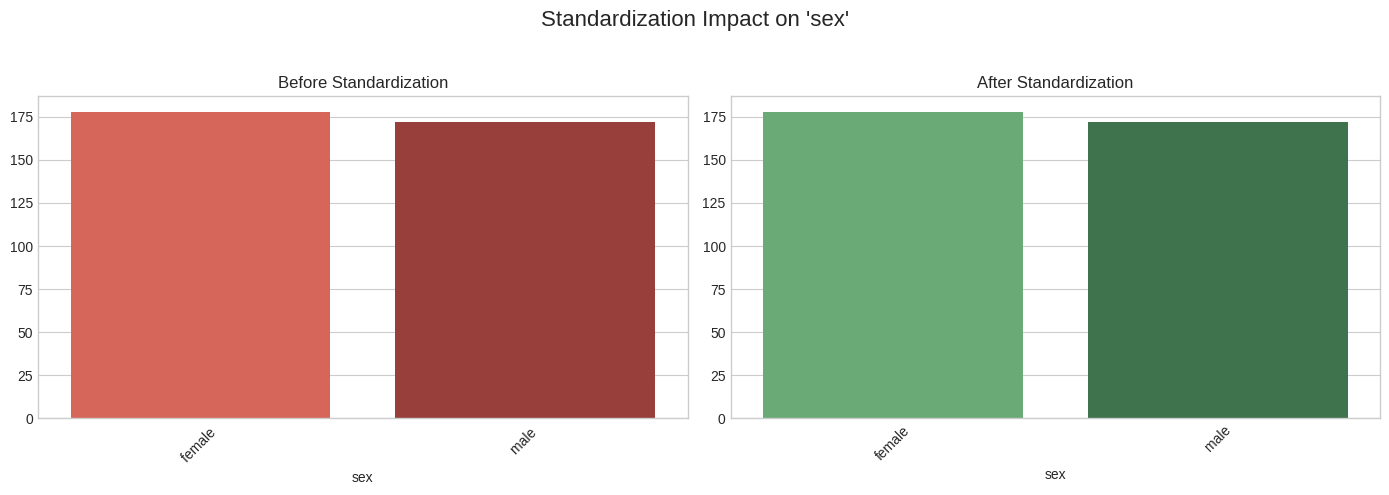


------------------------------------------------------------
🔎 Detailed Report for Column: 'transmission_rank'
   - Unique values reduced from 7 to 4.


,Before,After
transmission_rank,,
isolated,95,106
Tertiary,55,0
secondary,54,99
Index,54,0
Secondary,45,0
index,36,90
Isolated,11,0
tertiary,0,55


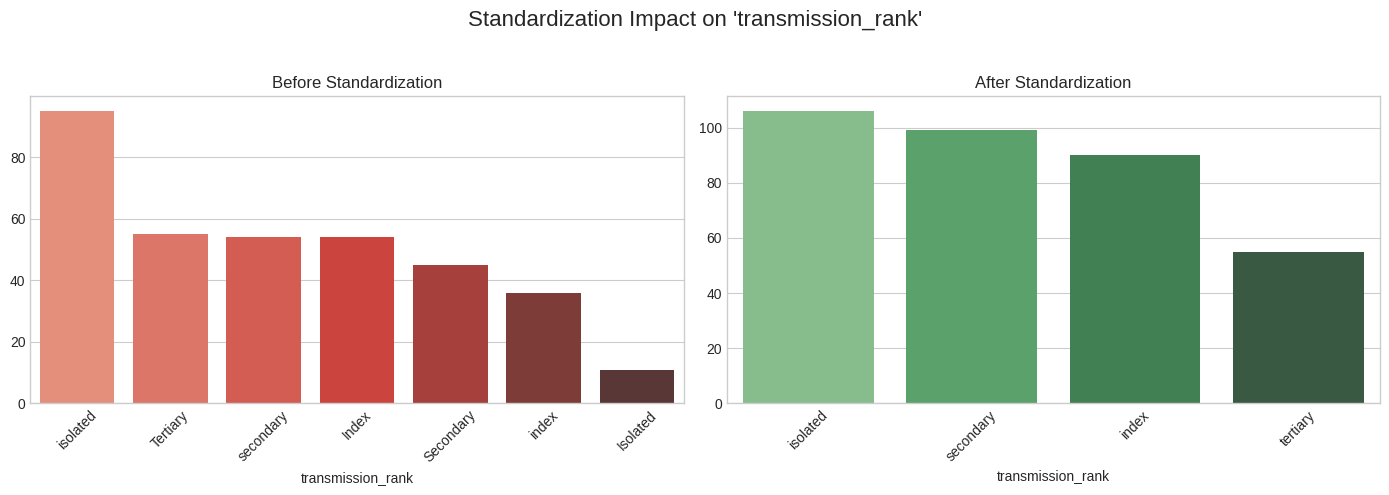


------------------------------------------------------------
🔎 Detailed Report for Column: 'country_of_acquisition'
   - Unique values reduced from 36 to 35.


,Before,After
country_of_acquisition,,
Nigeria,51,0
England,49,0
Uganda,29,0
Portugal,22,0
Spain,20,0
...,...,...
congo,0,1
finland,0,1
latvia,0,1


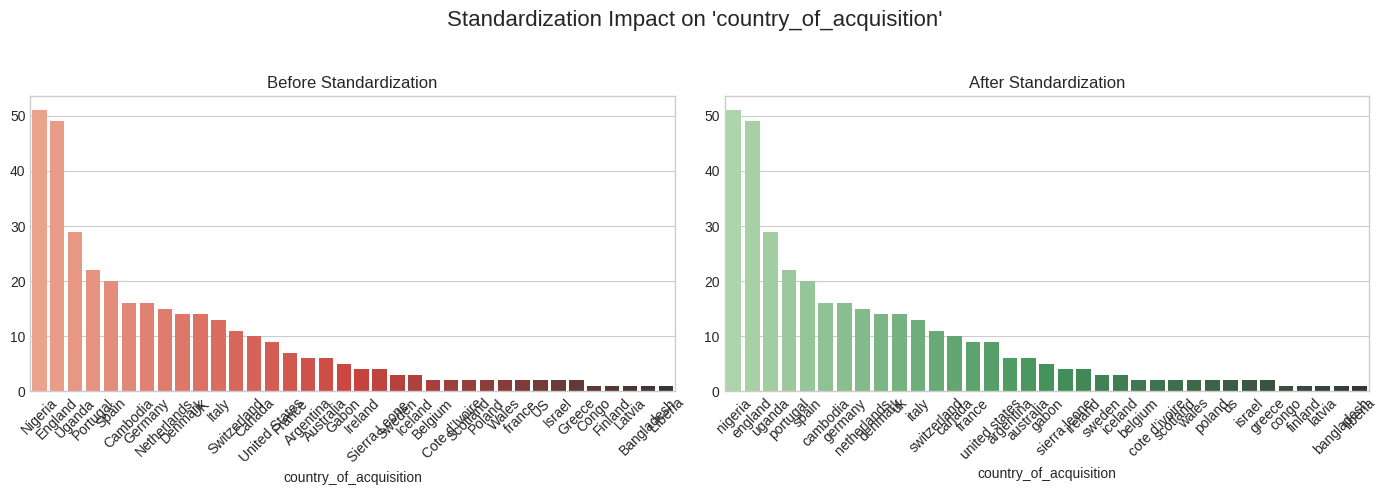


------------------------------------------------------------
🔎 Detailed Report for Column: 'smallpox_vaccination_history'
   - Unique values reduced from 3 to 3.


,Before,After
smallpox_vaccination_history,,
none,235,0
MVA six days post exposure or 12 days pre-illness,114,0
MVA six days post-exposure or 12 days pre-illness,1,0
no,0,235
mva six days post exposure or 12 days pre-illness,0,114
mva six days post-exposure or 12 days pre-illness,0,1


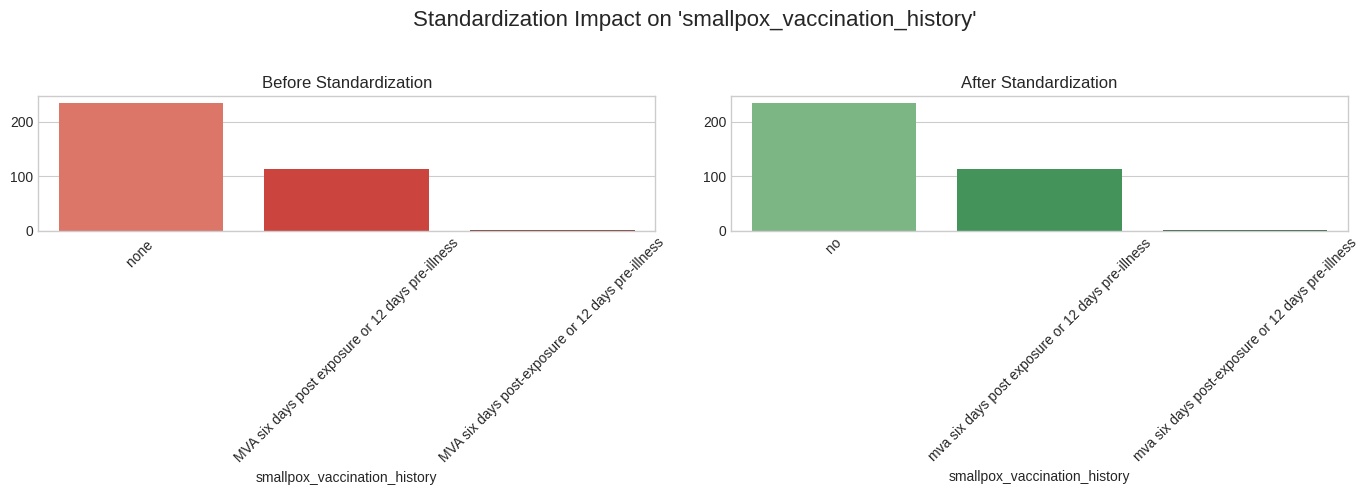


------------------------------------------------------------
🔎 Detailed Report for Column: 'hiv_hepatitis_b_and_hepatitis_c_status'
   - Unique values reduced from 3 to 3.


,Before,After
hiv_hepatitis_b_and_hepatitis_c_status,,
positive,208,0
negative,141,0
Not tested (parents negative),1,0
yes,0,208
no,0,141
not tested (parents negative),0,1


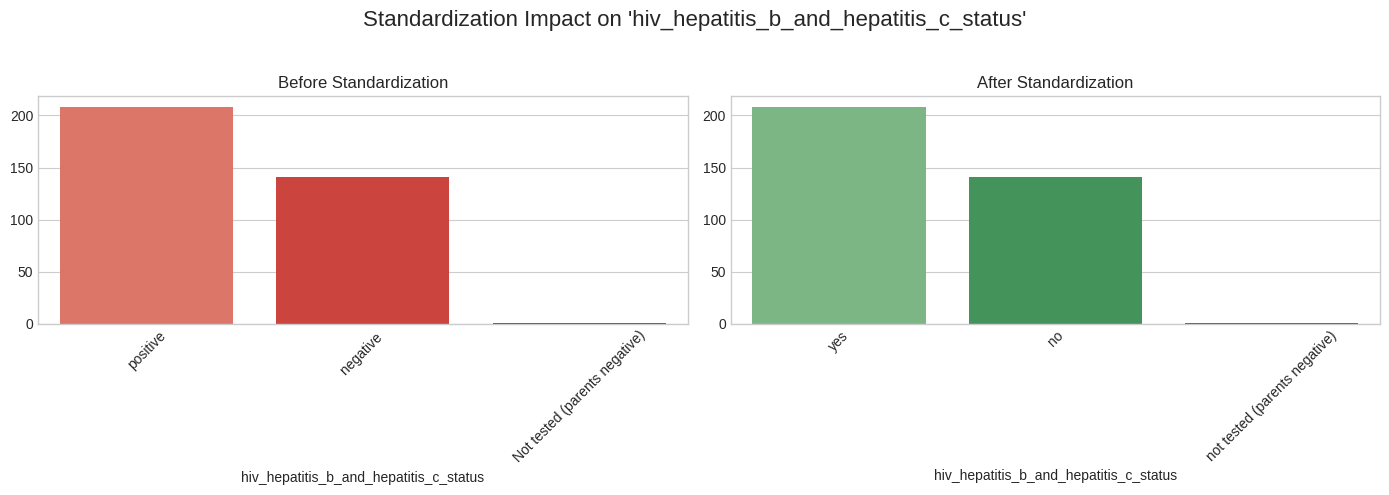


------------------------------------------------------------
🔎 Detailed Report for Column: 'fever'
   - Unique values reduced from 5 to 5.


,Before,After
fever,,
none,155,0
yes (2days),101,101
yes,37,37
Coryzal illness (1 day),30,0
yes (4days),27,27
no,0,155
coryzal illness (1 day),0,30


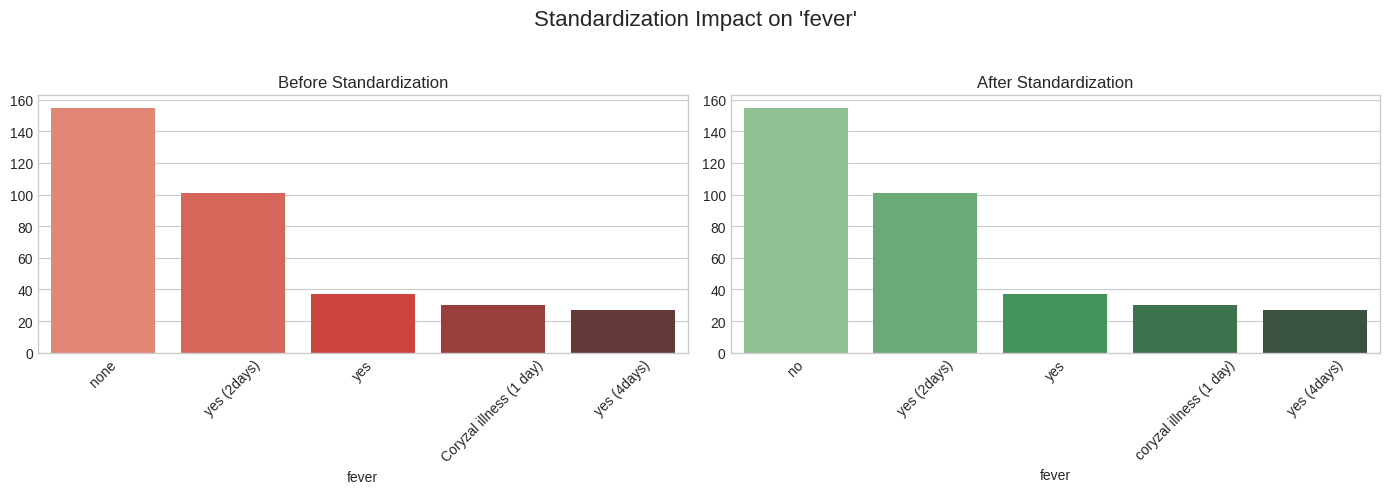


------------------------------------------------------------
🔎 Detailed Report for Column: 'rectal_pain_or_pain_on_defecation'
   - Unique values reduced from 2 to 2.


,Before,After
rectal_pain_or_pain_on_defecation,,
none,219,0
yes,131,131
no,0,219


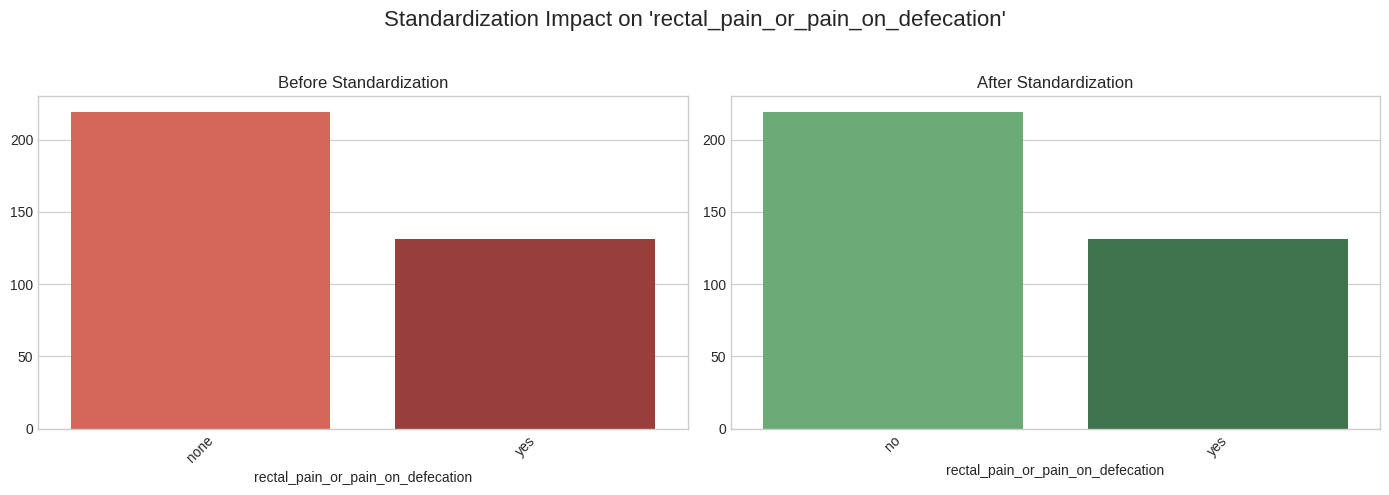


------------------------------------------------------------
🔎 Detailed Report for Column: 'dysuria'
   - Unique values reduced from 2 to 2.


,Before,After
dysuria,,
none,275,0
yes,75,75
no,0,275


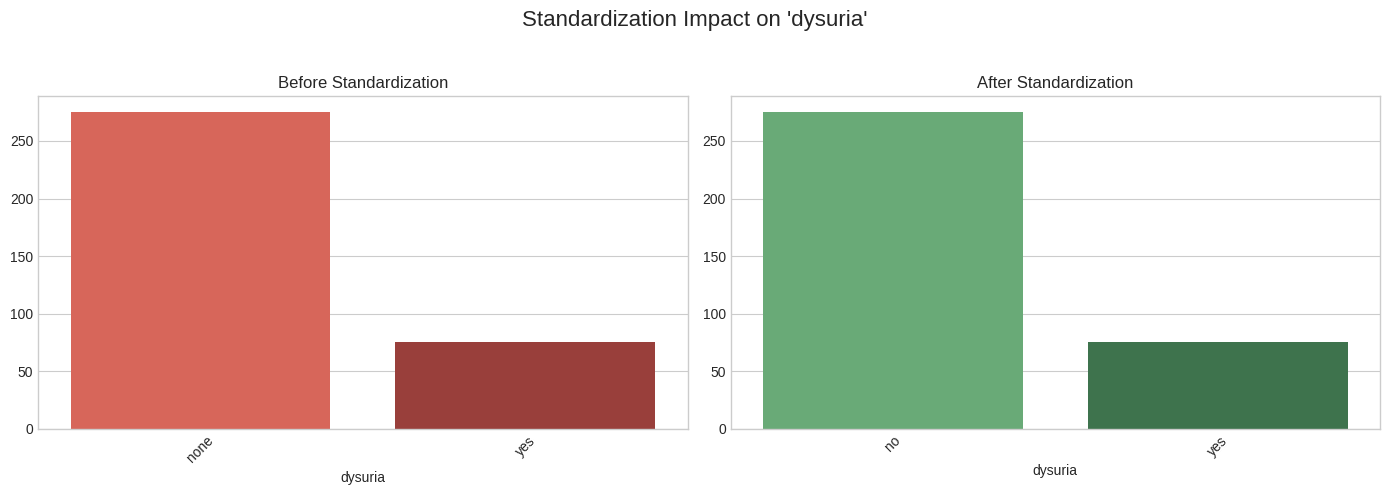


------------------------------------------------------------
🔎 Detailed Report for Column: 'bleedingdischarge_per_rectum'
   - Unique values reduced from 2 to 2.


,Before,After
bleedingdischarge_per_rectum,,
none,318,0
yes,32,32
no,0,318


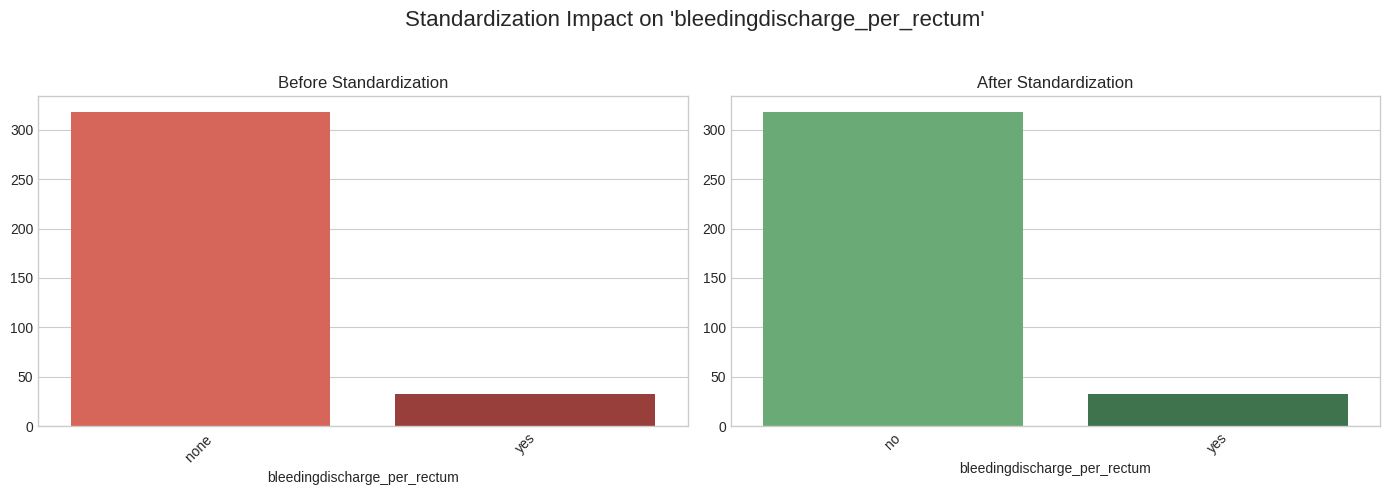


------------------------------------------------------------
🔎 Detailed Report for Column: 'conjunctivitis'
   - Unique values reduced from 2 to 2.


,Before,After
conjunctivitis,,
yes,178,178
none,172,0
no,0,172


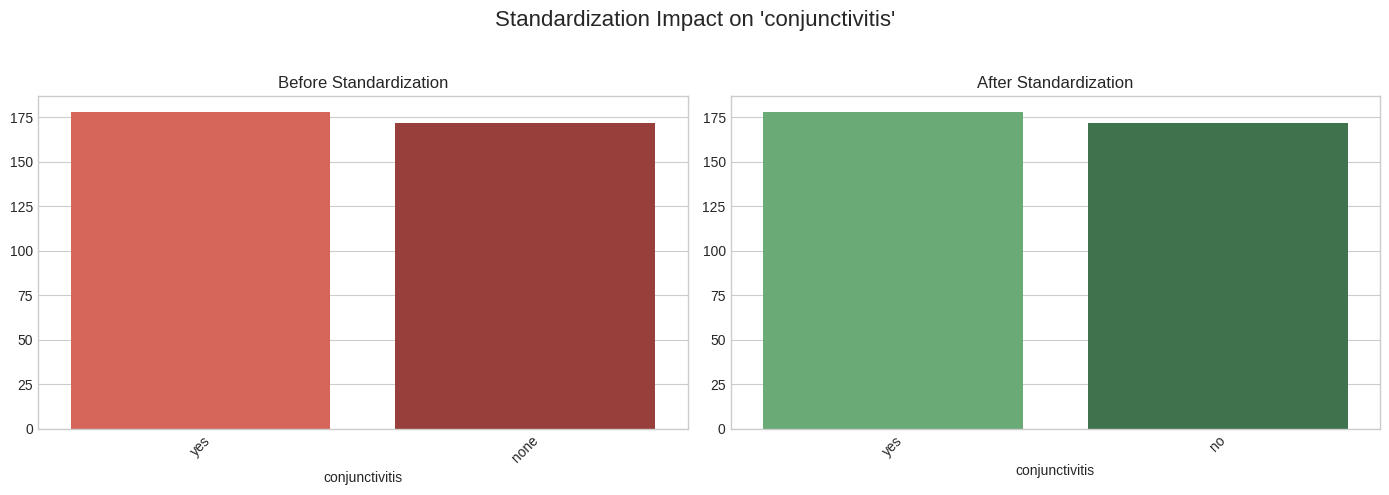


------------------------------------------------------------
🔎 Detailed Report for Column: 'back_pain'
   - Unique values reduced from 2 to 2.


,Before,After
back_pain,,
yes,240,240
none,110,0
no,0,110


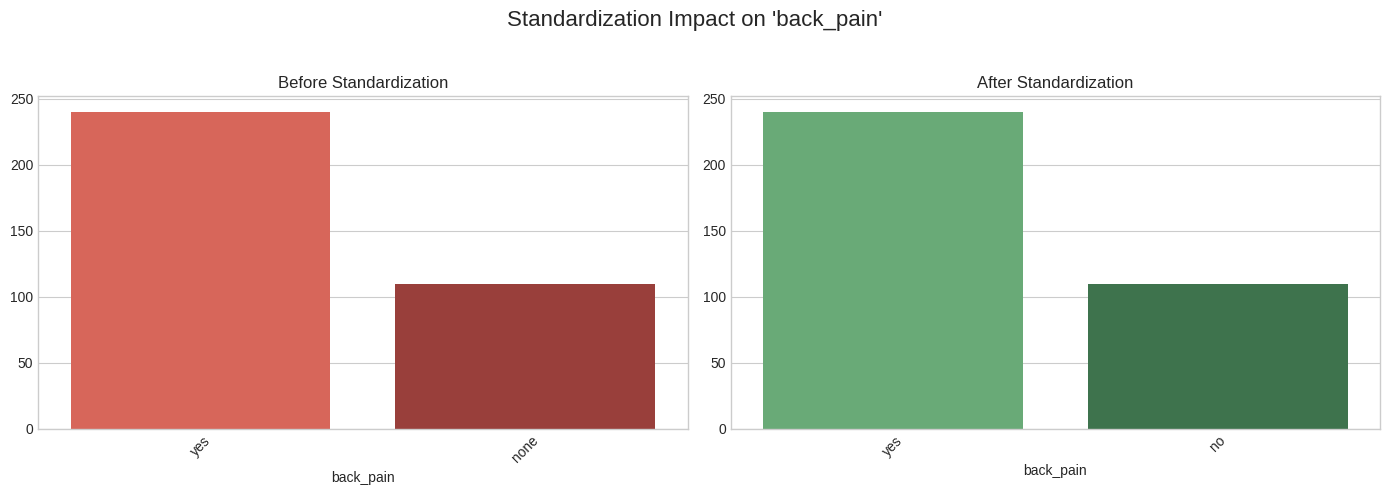


------------------------------------------------------------
🔎 Detailed Report for Column: 'myalgia'
   - Unique values reduced from 2 to 2.


,Before,After
myalgia,,
yes,280,280
none,70,0
no,0,70


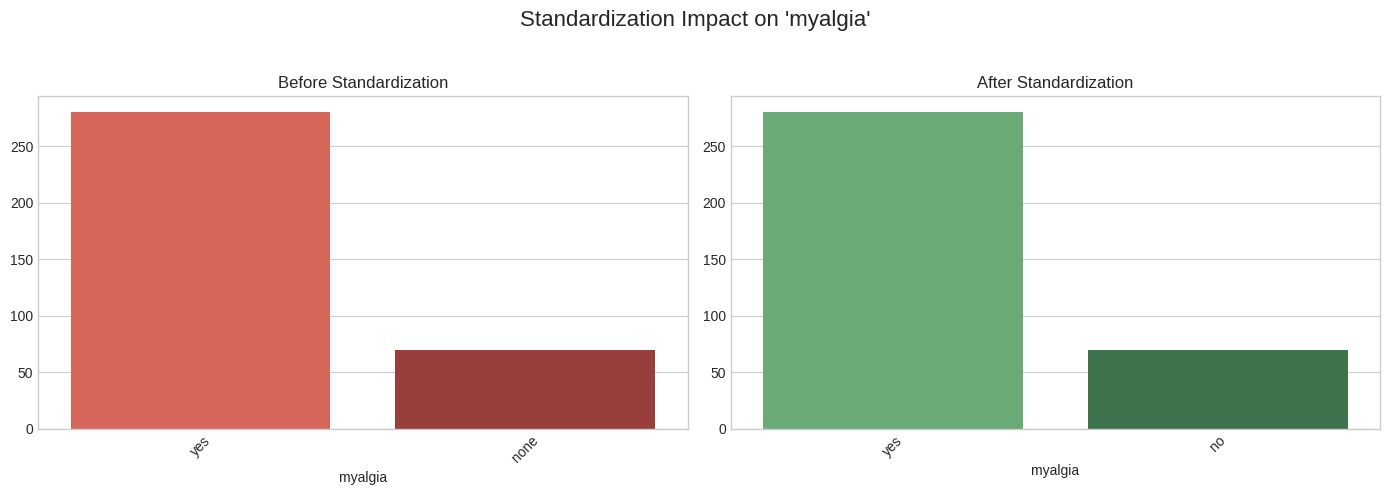


------------------------------------------------------------
🔎 Detailed Report for Column: 'headache'
   - Unique values reduced from 2 to 2.


,Before,After
headache,,
yes,271,271
none,79,0
no,0,79


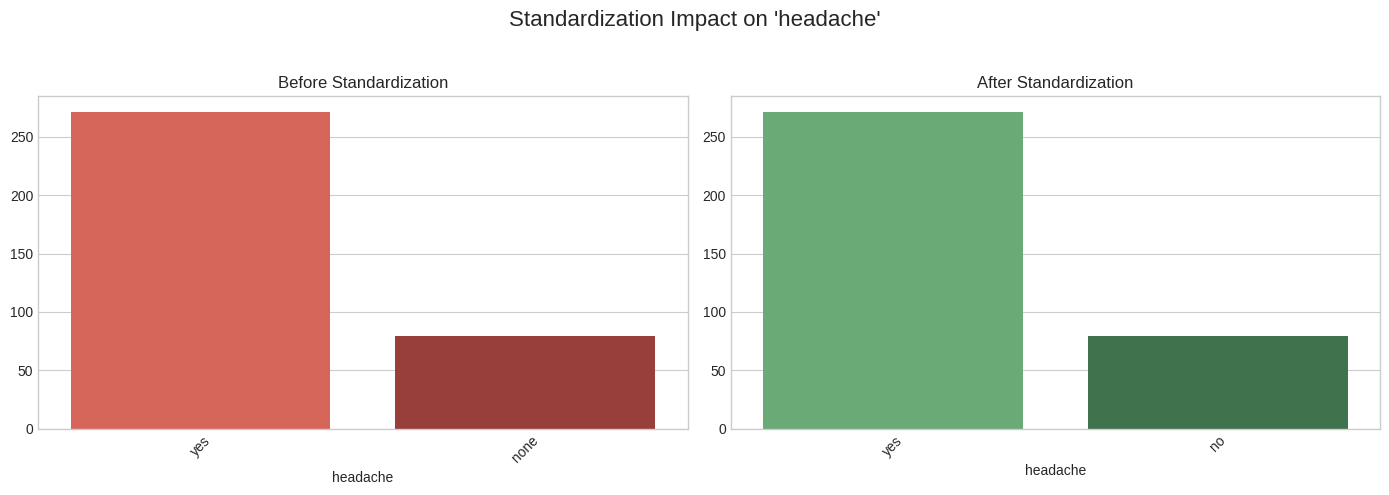


------------------------------------------------------------
🔎 Detailed Report for Column: 'lymphadenopathy'
   - Unique values reduced from 2 to 2.


,Before,After
lymphadenopathy,,
yes,228,228
none,122,0
no,0,122


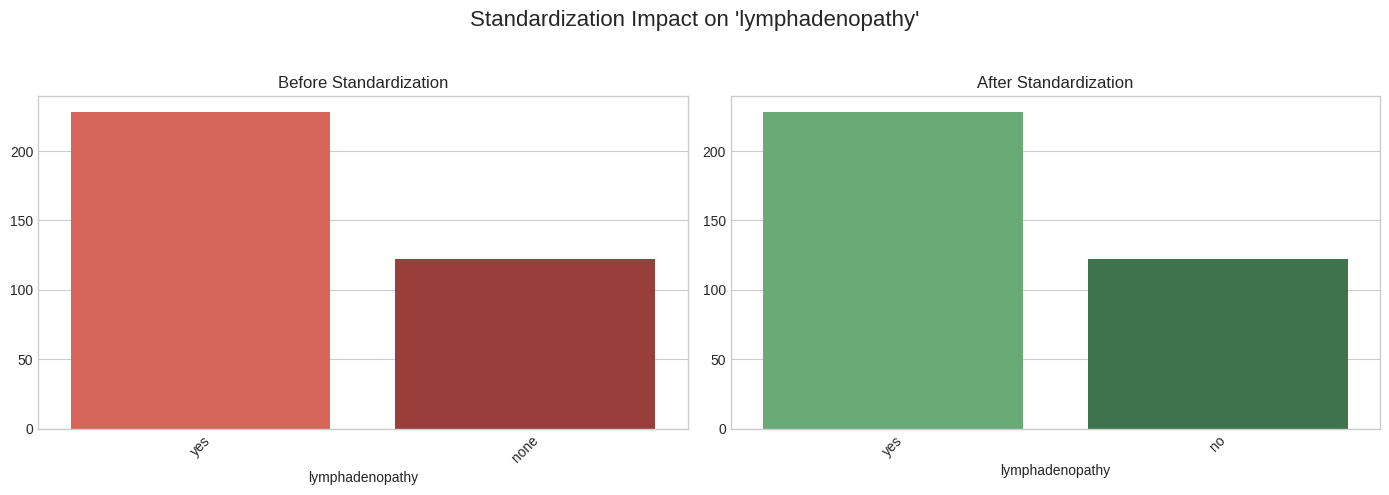


------------------------------------------------------------
🔎 Detailed Report for Column: 'sore_throat'
   - Unique values reduced from 2 to 2.


,Before,After
sore_throat,,
yes,254,254
none,96,0
no,0,96


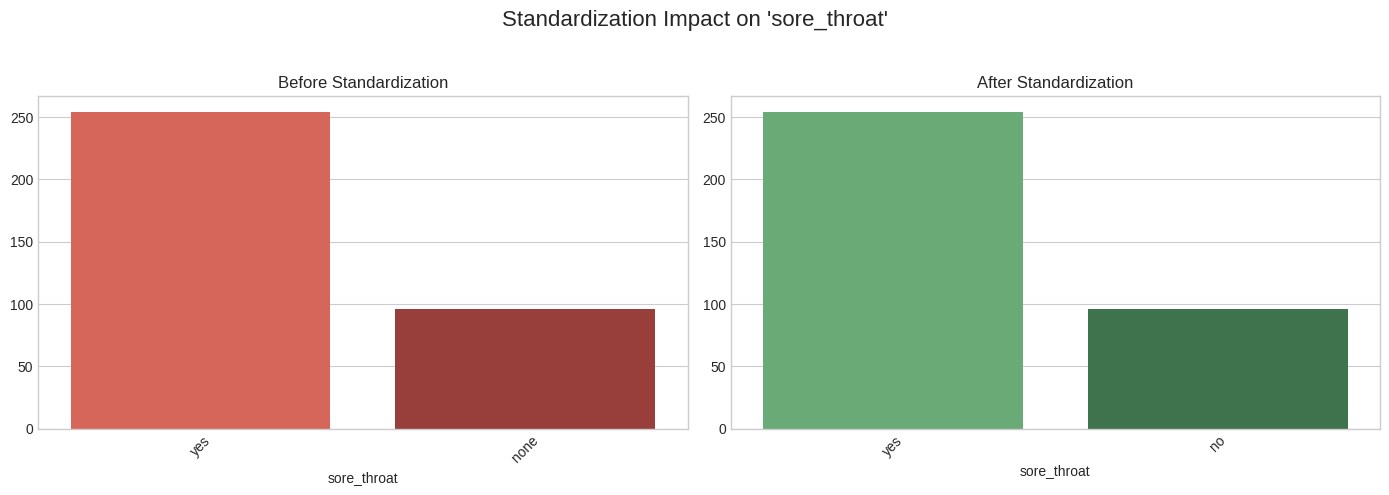


------------------------------------------------------------
🔎 Detailed Report for Column: 'chills'
   - Unique values reduced from 2 to 2.


,Before,After
chills,,
none,241,0
yes,109,109
no,0,241


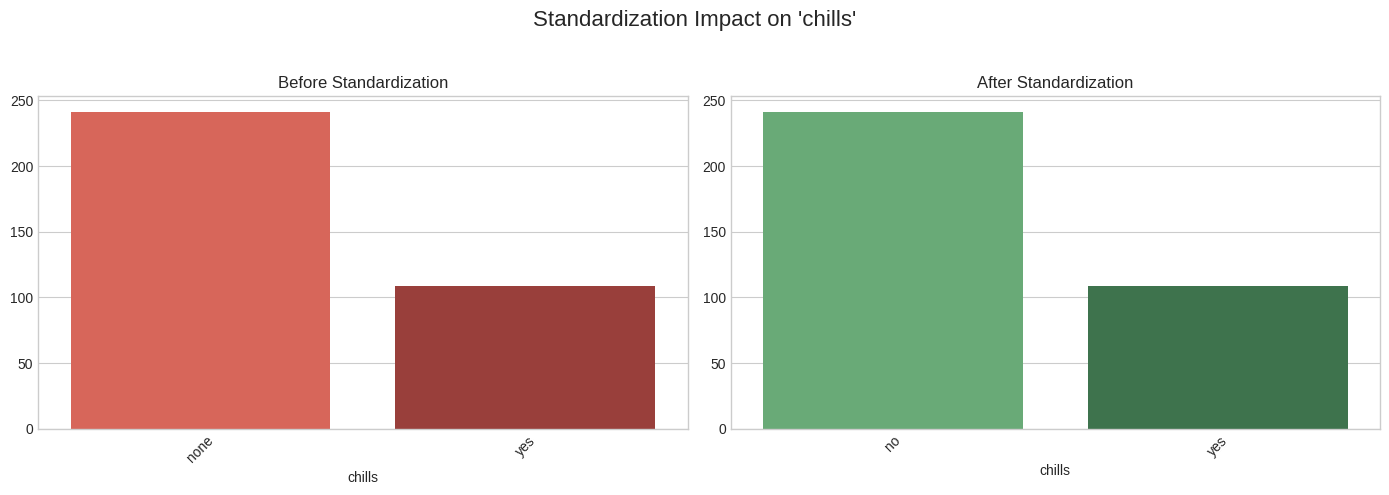


------------------------------------------------------------
🔎 Detailed Report for Column: 'rtpcr'
   - Unique values reduced from 5 to 3.


,Before,After
rtpcr,,
yes,162,164
no,132,132
unknown,53,54
yes,2,0
unknown,1,0


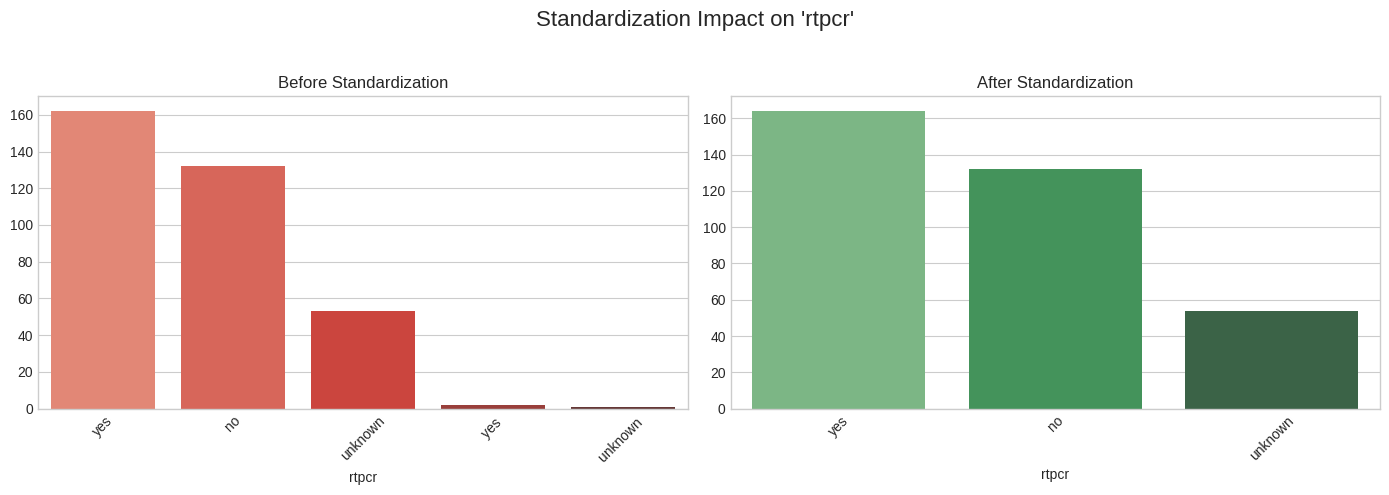


🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 4 SUCCESS: Categorical values have been consistently standardized across all data splits.
The data is now ready for missing value handling.
   - X_train_std shape: (350, 37)


In [ ]:
# =============================================================================
# STEP 4: VALUE STANDARDIZATION
# =============================================================================
import pandas as pd  # Library manipulasi data
import numpy as np  # Library untuk operasi numerik
import matplotlib.pyplot as plt  # Library visualisasi
import seaborn as sns  # Library visualisasi
from IPython.display import display  # Menampilkan DataFrame dengan rapi di notebook

class ValueStandardizer:
    """
    Standardizes categorical values consistently across train, validation, and test sets
    with detailed, presentation-ready reporting.
    # Tujuan: Menghindari inkonsistensi kategori seperti "Yes"/"yes"/"Y"/"1" di seluruh dataset.
    """
    def __init__(self, X_train, X_validation, X_test):
        # Work on copies to avoid modifying original dataframes from previous steps
        self.X_train = X_train.copy()  # Copy data train
        self.X_validation = X_validation.copy()  # Copy data validation
        self.X_test = X_test.copy()  # Copy data test
        self.report_data = [] # Stores detailed change logs # Menyimpan perubahan untuk laporan visual

    def run_standardization(self):
        """Executes the entire standardization pipeline."""
        print("\n" + "✨"*40)
        print("STEP 4: STANDARDIZING CATEGORICAL VALUES")
        print("✨"*40)

        self._standardize_values()  # Terapkan standardisasi
        self._generate_report_and_visuals()  # Buat laporan dan visualisasi perubahan

        return self.X_train, self.X_validation, self.X_test  # Kembalikan dataset yang telah distandarisasi

    def _standardize_values(self):
        """Applies cleaning and standardization rules to all three data splits."""
        print("1. Cleaning and standardizing values in Train, Validation, and Test sets...")

        # Define comprehensive mapping rules for standardization
        replace_map = {
            'y': 'yes', 'true': 'yes', '1': 'yes', 'positive': 'yes', 'present': 'yes', 'detected': 'yes',  # Semua format 'yes'
            'n': 'no', 'false': 'no', '0': 'no', 'negative': 'no', 'absent': 'no', 'not detected': 'no', 'none': 'no',  # Semua format 'no'
            'm': 'male', 'man': 'male',  # Gender male
            'f': 'female', 'woman': 'female',  # Gender female
            'na': 'unknown', 'n/a': 'unknown', 'not specified': 'unknown', '?': 'unknown'  # Nilai tidak diketahui
        }

        # Identify categorical columns from the training set
        categorical_cols = self.X_train.select_dtypes(include=['object', 'category']).columns  # Deteksi kolom kategori

        # Apply the same transformations consistently to all three sets
        for df in [self.X_train, self.X_validation, self.X_test]:
            for col in categorical_cols:
                if col in df.columns:
                    # Capture state BEFORE for the training set report
                    if df is self.X_train:
                        before_counts = df[col].value_counts()  # Hitung distribusi awal

                    # Apply cleaning (strip whitespace, lowercase) and then replace using the map
                    df[col] = df[col].astype(str).str.strip().str.lower().replace(replace_map)  # Bersihkan dan standar

                    # Capture state AFTER for the training set report
                    if df is self.X_train:
                        after_counts = df[col].value_counts()  # Hitung distribusi setelah standar
                        # If any changes occurred, log them for the report
                        if not before_counts.equals(after_counts):
                            self.report_data.append({
                                'column': col,  # Nama kolom
                                'before_counts': before_counts,  # Distribusi sebelum standar
                                'after_counts': after_counts,  # Distribusi sesudah standar
                                'unique_before': len(before_counts),  # Jumlah nilai unik awal
                                'unique_after': len(after_counts)  # Jumlah nilai unik akhir
                            })

        print(f"   ✅ Standardization rules applied to {len(categorical_cols)} categorical columns.")  # Laporan jumlah kolom

    def _generate_report_and_visuals(self):
        """Generates a detailed, visual report of the standardization on the training set."""
        print("\n" + "📋"*40)
        print("COMPREHENSIVE STANDARDIZATION REPORT (Based on Training Set)")
        print("📋"*40)

        if not self.report_data:
            print("✅ No values required standardization. All categorical data is already clean.")  # Tidak ada perubahan
            return

        print(f"Found {len(self.report_data)} column(s) with values that were standardized.")  # Jumlah kolom yang berubah

        for report in self.report_data:
            col, before_df, after_df = report['column'], report['before_counts'].to_frame('Before'), report['after_counts'].to_frame('After')
            comparison_df = pd.concat([before_df, after_df], axis=1).fillna(0).astype(int)  # Gabungkan tabel before/after

            print("\n" + "-"*60)
            print(f"🔎 Detailed Report for Column: '{col}'")
            print(f"   - Unique values reduced from {report['unique_before']} to {report['unique_after']}.")  # Info ringkas
            display(comparison_df)  # Tampilkan tabel before/after

            # Create side-by-side visualizations
            fig, axes = plt.subplots(1, 2, figsize=(14, 5)); fig.suptitle(f"Standardization Impact on '{col}'", fontsize=16)
            sns.barplot(x=report['before_counts'].index, y=report['before_counts'].values, ax=axes[0], palette='Reds_d'); axes[0].set_title("Before Standardization"); axes[0].tick_params(axis='x', rotation=45)
            sns.barplot(x=report['after_counts'].index, y=report['after_counts'].values, ax=axes[1], palette='Greens_d'); axes[1].set_title("After Standardization"); axes[1].tick_params(axis='x', rotation=45)
            plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()  # Visualisasi per kolom

# =============================================================================
# EXECUTION FOR STEP 4
# =============================================================================
# This step runs AFTER Step 3 (Data Splitting)
if 'X_train' in locals():
    print("\n" + "="*80)
    print("🚀 STARTING STEP 4: VALUE STANDARDIZATION")
    print("="*80)

    # Initialize the standardizer with the three data splits
    standardizer = ValueStandardizer(X_train, X_validation, X_test)  # Inisialisasi class

    # Run the process
    X_train_std, X_validation_std, X_test_std = standardizer.run_standardization()  # Jalankan standardisasi

    print("\n" + "🎉"*60)
    print("STEP 4 SUCCESS: Categorical values have been consistently standardized across all data splits.")  # Konfirmasi sukses
    print("The data is now ready for missing value handling.")  # Next step
    print(f"   - X_train_std shape: {X_train_std.shape}")  # Ukuran dataset
    print("="*80)
else:
    print("🛑 Could not run Step 4 because the split data (`X_train`, etc.) from Step 3 was not found.")  # Error handling


<details>
<summary>📌 Step 5: Missing Value Analysis & Handling</summary>

**Deskripsi Step 5:**

- **Tujuan:** Mendeteksi, menganalisis, dan menangani semua nilai yang hilang (missing values) di dataset sebelum melanjutkan ke modeling.  
- **Mengapa penting:**  
  1. Missing values dapat menyebabkan error atau bias saat training model.  
  2. Penanganan yang salah bisa menimbulkan *data leakage* jika informasi dari validation/test ikut dipakai untuk imputasi.  
  3. Analisis mendalam membantu memilih strategi imputasi yang tepat (median untuk numerik, mode untuk kategorikal).  
- **Apa yang dilakukan di kode ini:**  
  1. Analisis missing values di dataset asli (`df_final_step2`) untuk menentukan kolom yang perlu diimputasi.  
  2. Visualisasi pola missing values secara komprehensif (heatmap, barplot, pie chart, distribusi).  
  3. Imputasi dilakukan hanya dengan informasi dari **training set** untuk menghindari *data leakage*.  
  4. Transformasi diterapkan konsisten pada **X_train, X_validation, dan X_test**.  
  5. Menyediakan laporan final untuk memastikan semua missing values telah ditangani dengan benar.

</details>


In [ ]:
# =============================================================================
# STEP 5: MISSING VALUE HANDLING (FINAL REVISION WITH LEAKAGE FIX)
# =============================================================================
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

class ComprehensiveMissingValueHandler:
    """
    Analyzes missing values, then imputes them correctly on pre-split data
    using a revised logic to prevent data leakage.
    """
    def __init__(self):
        self.imputation_plan = None
        # [REVISI] Siapkan imputer di awal untuk disimpan setelah di-fit
        self.num_imputer = SimpleImputer(strategy='median')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')
        self.num_cols_to_impute = []
        self.cat_cols_to_impute = []

    def run_pipeline(self, df_original, X_train, X_validation, X_test):
        """Executes the full analysis and imputation pipeline."""
        self._analyze_missing_values(df_original)

        if self.imputation_plan is None or self.imputation_plan.empty:
            print("✅ No missing values to impute. Returning original data sets.")
            return X_train, X_validation, X_test

        return self._execute_imputation(X_train, X_validation, X_test)

    def _analyze_missing_values(self, df):
        """Performs analysis on the original data to generate an imputation plan."""
        print("\n" + "📊"*40)
        print("PART 1: DEEP ANALYSIS OF MISSING VALUES (PLANNING STAGE)")
        print("📊"*40)
        missing = df.isnull().sum()
        missing = missing[missing > 0]
        if missing.empty:
            self.imputation_plan = pd.DataFrame()
            return

        print(f"Found {len(missing)} columns with missing values. Generating analysis and strategy plan...")
        plan_details = [{'Column': col, 'Missing Count': count, 'Missing (%)': f"{(count / len(df)) * 100:.1f}%",
                         'Data Type': str(df[col].dtype), 'Recommended Strategy': "Median" if pd.api.types.is_numeric_dtype(df[col]) else "Mode"}
                        for col, count in missing.items()]
        self.imputation_plan = pd.DataFrame(plan_details).sort_values(by='Missing Count', ascending=False)
        print("\n📋 Imputation Plan Summary:")
        display(self.imputation_plan.style.background_gradient(cmap='Reds', subset=['Missing Count']))
        # Visualisasi tidak diubah karena hanya untuk analisis
        self._create_advanced_missing_visualizations(df)

    def _create_advanced_missing_visualizations(self, df):
        # ... (Fungsi ini tidak perlu diubah) ...
        print("\n📈 Generating Advanced Missing Value Visualizations...")
        fig, axes = plt.subplots(2, 3, figsize=(22, 12)); fig.suptitle('Advanced Missing Values Analysis', fontsize=18, fontweight='bold')
        missing_df = self.imputation_plan; total_missing_pct = df.isnull().sum().sum() / df.size * 100
        sns.heatmap(df[missing_df['Column']].isnull(), cbar=False, cmap='viridis_r', ax=axes[0, 0]); axes[0, 0].set_title('Missing Values Heatmap Pattern', fontsize=14)
        top_10 = missing_df.head(10); sns.barplot(x='Missing Count', y='Column', data=top_10, ax=axes[0, 1], palette='viridis'); axes[0, 1].set_title('Top 10 Columns with Missing Values', fontsize=14)
        axes[0, 2].pie([100 - total_missing_pct, total_missing_pct], labels=['Complete Data', 'Missing Data'], colors=['#4CAF50', '#F44336'], autopct='%1.1f%%', startangle=90); axes[0, 2].set_title('Overall Data Completeness', fontsize=14)
        type_counts = missing_df.groupby('Data Type')['Missing Count'].sum(); sns.barplot(x=type_counts.index, y=type_counts.values, ax=axes[1, 0], palette='plasma'); axes[1, 0].set_title('Total Missing Values by Data Type', fontsize=14); axes[1, 0].set_ylabel('Total Missing Count')
        strategy_counts = missing_df['Recommended Strategy'].value_counts(); sns.barplot(x=strategy_counts.index, y=strategy_counts.values, ax=axes[1, 1], palette='magma'); axes[1, 1].set_title('Planned Imputation Strategies', fontsize=14); axes[1, 1].set_ylabel('Number of Columns to Impute')
        missing_pcts = [float(p.strip('%')) for p in missing_df['Missing (%)']]; sns.histplot(missing_pcts, bins=10, kde=True, ax=axes[1, 2], color='teal'); axes[1, 2].set_title('Distribution of Missing Percentages', fontsize=14); axes[1, 2].set_xlabel('Missing Percentage (%)')
        plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.show()

    def _execute_imputation(self, X_train, X_validation, X_test):
        """
        [REVISED] Executes the imputation using the correct anti-data leakage workflow.
        """
        print("\n" + "⚡"*40)
        print("PART 2: EXECUTING IMPUTATION ON SPLIT DATA (CORRECT LOGIC)")
        print("⚡"*40)

        # Ambil daftar kolom dari rencana yang sudah dibuat
        self.num_cols_to_impute = self.imputation_plan[self.imputation_plan['Recommended Strategy'] == 'Median']['Column'].tolist()
        self.cat_cols_to_impute = self.imputation_plan[self.imputation_plan['Recommended Strategy'] == 'Mode']['Column'].tolist()

        # Pastikan kolom-kolom tersebut ada di X_train
        self.num_cols_to_impute = [col for col in self.num_cols_to_impute if col in X_train.columns]
        self.cat_cols_to_impute = [col for col in self.cat_cols_to_impute if col in X_train.columns]

        # Salin data untuk menghindari SettingWithCopyWarning
        X_train_imputed = X_train.copy()
        X_validation_imputed = X_validation.copy()
        X_test_imputed = X_test.copy()

        # --- INTI PERBAIKAN: FIT, LALU TRANSFORM SECARA TERPISAH ---
        print("1. Fitting imputers ONLY on the TRAINING data...")
        if self.num_cols_to_impute:
            self.num_imputer.fit(X_train[self.num_cols_to_impute])
        if self.cat_cols_to_impute:
            self.cat_imputer.fit(X_train[self.cat_cols_to_impute])

        print("2. Transforming TRAIN, VALIDATION, and TEST data separately...")
        if self.num_cols_to_impute:
            X_train_imputed[self.num_cols_to_impute] = self.num_imputer.transform(X_train[self.num_cols_to_impute])
            X_validation_imputed[self.num_cols_to_impute] = self.num_imputer.transform(X_validation[self.num_cols_to_impute])
            X_test_imputed[self.num_cols_to_impute] = self.num_imputer.transform(X_test[self.num_cols_to_impute])

        if self.cat_cols_to_impute:
            X_train_imputed[self.cat_cols_to_impute] = self.cat_imputer.transform(X_train[self.cat_cols_to_impute])
            X_validation_imputed[self.cat_cols_to_impute] = self.cat_imputer.transform(X_validation[self.cat_cols_to_impute])
            X_test_imputed[self.cat_cols_to_impute] = self.cat_imputer.transform(X_test[self.cat_cols_to_impute])

        self._generate_imputation_report(X_train_imputed, X_validation_imputed, X_test_imputed)
        return X_train_imputed, X_validation_imputed, X_test_imputed

    def _generate_imputation_report(self, X_train, X_validation, X_test):
        """Generates the final summary report of imputation actions."""
        # ... (Fungsi ini tidak perlu diubah) ...
        print("\n" + "📋"*40); print("PART 3: IMPUTATION EXECUTION REPORT"); print("📋"*40)
        print("\nFinal Verification:")
        print(f"   - Missing values remaining in X_train: {X_train.isnull().sum().sum()}")
        print(f"   - Missing values in X_validation: {X_validation.isnull().sum().sum()}")
        print(f"   - Missing values in X_test: {X_test.isnull().sum().sum()}")
        if X_train.isnull().sum().sum() == 0: print("   - ✅ SUCCESS. All missing values have been handled correctly.")
        else: print("   - ⚠️ WARNING. Some missing values remain.")

# =============================================================================
# EXECUTION FOR STEP 5 (Tidak ada perubahan di sini)
# =============================================================================
if 'X_train_std' in locals():
    print("\n" + "="*80)
    print("🚀 STARTING STEP 5: MISSING VALUE ANALYSIS & HANDLING")
    print("="*80)

    handler = ComprehensiveMissingValueHandler()

    # Run the pipeline: Analyze on original, Impute on all three splits
    X_train_imputed, X_validation_imputed, X_test_imputed = handler.run_pipeline(
        df_final_step2, X_train_std, X_validation_std, X_test_std
    )

    print("\n" + "🎉"*60)
    print("STEP 5 SUCCESS: Missing values have been handled correctly across all data splits.")
    print("="*80)

else:
    print("🛑 Could not run Step 5 because the standardized data (`X_train_std`, etc.) from Step 4 was not found.")


🚀 STARTING STEP 5: MISSING VALUE ANALYSIS & HANDLING

📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
PART 1: DEEP ANALYSIS OF MISSING VALUES (PLANNING STAGE)
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
✅ No missing values to impute. Returning original data sets.

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
STEP 5 SUCCESS: Missing values have been handled correctly across all data splits.


<details>
<summary>📖 Penjelasan Step 6: Feature Engineering, Encoding, & Scaling</summary>

**Step 6** adalah tahap final preprocessing sebelum model training. Berikut rinciannya:

---

### 🔹 6.1 Feature Engineering
- Membuat fitur baru berdasarkan domain knowledge:
  - `symptom_score`: jumlah gejala 'yes' yang dialami pasien.
  - `symptom_severity`: kategori keparahan gejala berdasarkan kuantil train set.
  - `age_group`: kelompok umur berdasarkan batas tertentu (0–18, 19–40, 41–65, 66+).
- Semua fitur baru diterapkan konsisten ke **train, validation, dan test set**.

### 🔹 6.2 Encoding & Handling Cardinality
- Pisahkan kolom kategori menjadi:
  - **Low-cardinality (≤10 unique values)** → One-Hot Encoding (OHE).
  - **High-cardinality (>10 unique values)** → dihapus untuk menghindari sparsity.
- OHE **fit hanya di train set**, lalu transform diterapkan ke semua split.
- Menjamin tidak terjadi data leakage.

### 🔹 6.3 Scaling Numerical Features
- Semua fitur numerik di-scale menggunakan **StandardScaler**:
  - Fit hanya di train set.
  - Transform diterapkan ke train, validation, dan test set.
- Menjaga skala fitur agar model tidak bias terhadap range numerik tertentu.
- Statistik sebelum & sesudah scaling ditampilkan untuk monitoring.

### 🔹 6.4 Final Report
- Menampilkan shape final untuk **X_train_final, X_validation_final, X_test_final**.
- Menyediakan preview data train yang sudah siap untuk model training.

---

✅ Setelah Step 6, data sudah:
- Bebas missing values.
- Fitur kategori & numerik sudah siap.
- Split data konsisten untuk train, validation, dan test.
- Siap untuk proses model building atau evaluasi.

</details>


In [ ]:
# =============================================================================
# STEP 6: FEATURE ENGINEERING, ENCODING, & SCALING (ULTIMATE FINAL VERSION)
# =============================================================================
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # Preprocessing tools
import pandas as pd
import numpy as np
from IPython.display import display  # Untuk menampilkan dataframe/summary

class FeaturePipeline:
    """
    A comprehensive pipeline for all post-split transformations.
    Handles feature engineering, encoding, and scaling across train, validation, and test sets.
    """
    def __init__(self, X_train, X_validation, X_test):
        self.X_train = X_train.copy()  # Copy agar data asli tetap aman
        self.X_validation = X_validation.copy()
        self.X_test = X_test.copy()
        self.learned_params = {}  # Menyimpan parameter yang dipelajari dari training
        self.report = {}  # Untuk menyimpan laporan final pipeline

    def run_pipeline(self):
        """Eksekusi seluruh pipeline fitur."""
        print("\n" + "🛠️"*40)
        print("STEP 6: FEATURE ENGINEERING, ENCODING, AND SCALING")
        print("🛠️"*40)

        self._engineer_features()  # Sub-step 6.1
        self._encode_and_handle_cardinality()  # Sub-step 6.2
        self._scale_numerical_features()  # Sub-step 6.3
        self._generate_final_report()  # Sub-step 6.4

        return self.X_train, self.X_validation, self.X_test

    def _engineer_features(self):
        """[SUB-STEP 6.1] Membuat fitur baru berdasarkan domain knowledge."""
        print("\n--- 6.1: Engineering New Features ---")

        def create_features(df, params, is_train=False):
            symptom_cols = ['fever', 'chills', 'sore_throat', 'rectal_pain_or_pain_on_defecation', 'headache', 'myalgia']
            symptom_cols_exist = [c for c in symptom_cols if c in df.columns]

            df['symptom_score'] = df[symptom_cols_exist].apply(lambda row: sum(1 for val in row if val == 'yes'), axis=1)  # Hitung jumlah gejala

            if is_train:
                params['symptom_quantiles'] = df['symptom_score'].quantile([0.33, 0.66]).tolist()  # Simpan kuantil dari train set

            quantiles = params.get('symptom_quantiles', [0, 0])
            df['symptom_severity'] = pd.cut(df['symptom_score'], bins=[-np.inf, quantiles[0], quantiles[1], np.inf], labels=[0,1,2]).astype(int)  # Severity berdasarkan kuantil

            if 'age' in df.columns:
                df['age_group'] = pd.cut(df['age'], bins=[0,18,40,65,np.inf], labels=[0,1,2,3], include_lowest=True).astype(int)  # Group umur

            return df

        # Terapkan feature engineering ke semua split
        self.X_train = create_features(self.X_train, self.learned_params, is_train=True)
        self.X_validation = create_features(self.X_validation, self.learned_params)
        self.X_test = create_features(self.X_test, self.learned_params)

        new_features = [col for col in ['symptom_score', 'symptom_severity', 'age_group'] if col in self.X_train.columns]
        self.report['engineered_features'] = new_features
        print(f"   ✅ Created {len(new_features)} new features: {new_features}")

    def _encode_and_handle_cardinality(self):
        """[SUB-STEP 6.2] Encode categorical features dan tangani high-cardinality."""
        print("\n--- 6.2: Encoding Categorical Features ---")
        categorical_cols = self.X_train.select_dtypes(include=['object', 'category']).columns.tolist()
        low_cardinality_cols = [col for col in categorical_cols if self.X_train[col].nunique() <= 10]  # Kolom aman untuk OHE
        high_cardinality_cols = [col for col in categorical_cols if self.X_train[col].nunique() > 10]  # Drop kolom terlalu banyak kategori

        print(f"   - Dropping {len(high_cardinality_cols)} high-cardinality columns: {high_cardinality_cols}")
        self.X_train.drop(columns=high_cardinality_cols, inplace=True)
        self.X_validation.drop(columns=high_cardinality_cols, inplace=True)  # Konsisten
        self.X_test.drop(columns=high_cardinality_cols, inplace=True)

        if not low_cardinality_cols: print("   - No low-cardinality columns to encode."); return

        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.int8)  # Encoder
        ohe.fit(self.X_train[low_cardinality_cols])  # Fit di training set

        def encode_df(df, encoder, columns_to_encode):
            encoded_df = pd.DataFrame(encoder.transform(df[columns_to_encode]), columns=encoder.get_feature_names_out(), index=df.index)
            return pd.concat([df.drop(columns=columns_to_encode), encoded_df], axis=1)

        # Terapkan encoding ke semua split
        self.X_train = encode_df(self.X_train, ohe, low_cardinality_cols)
        self.X_validation = encode_df(self.X_validation, ohe, low_cardinality_cols)
        self.X_test = encode_df(self.X_test, ohe, low_cardinality_cols)
        print(f"   - Applied One-Hot Encoding to {len(low_cardinality_cols)} columns.")

    def _scale_numerical_features(self):
        """[SUB-STEP 6.3] Scaling numerical features dengan StandardScaler."""
        print("\n--- 6.3: Scaling Numerical Features ---")
        numerical_cols = self.X_train.select_dtypes(include=np.number).columns.tolist()
        if not numerical_cols: print("   - No numerical features to scale."); return

        print(f"   - Found {len(numerical_cols)} numerical features to scale.")
        print("\n   🔬 Statistics BEFORE Scaling (from Training Set):")
        display(self.X_train[numerical_cols].describe().round(2))

        scaler = StandardScaler()
        scaler.fit(self.X_train[numerical_cols])  # Fit hanya di train set

        # Terapkan scaling ke semua split
        self.X_train[numerical_cols] = scaler.transform(self.X_train[numerical_cols])
        self.X_validation[numerical_cols] = scaler.transform(self.X_validation[numerical_cols])
        self.X_test[numerical_cols] = scaler.transform(self.X_test[numerical_cols])

        print("\n   🔬 Statistics AFTER Scaling (from Training Set):")
        display(self.X_train[numerical_cols].describe().round(2))

    def _generate_final_report(self):
        """[SUB-STEP 6.4] Laporan akhir Step 6."""
        print("\n" + "📋"*40); print("FINAL REPORT FOR STEP 6"); print("📋"*40)
        print("\nFinal Data Shapes:")
        print(f"   - Processed Training Features (X_train_final): {self.X_train.shape}")
        print(f"   - Processed Validation Features (X_validation_final): {self.X_validation.shape}")
        print(f"   - Processed Testing Features (X_test_final):  {self.X_test.shape}")

# =============================================================================
# EXECUTION FOR STEP 6
# =============================================================================

if 'X_train_imputed' in locals():
    print("\n" + "="*80); print("🚀 STARTING STEP 6: FEATURE ENGINEERING, ENCODING, & SCALING"); print("="*80)

    pipeline = FeaturePipeline(X_train_imputed, X_validation_imputed, X_test_imputed)  # Inisialisasi pipeline
    X_train_final, X_validation_final, X_test_final = pipeline.run_pipeline()  # Jalankan pipeline

    print("\n" + "🏁"*60); print("ENTIRE PREPROCESSING PIPELINE IS COMPLETE!"); print("🏁"*60)
    print("The following data is now 100% ready for training and evaluation:")
    print(f"   - `X_train_final`      (Shape: {X_train_final.shape})")
    print(f"   - `X_validation_final` (Shape: {X_validation.shape})")
    print(f"   - `X_test_final`       (Shape: {X_test_final.shape})")
    print(f"   - `y_train`            (Shape: {y_train.shape})")
    print(f"   - `y_validation`       (Shape: {y_validation.shape})")
    print(f"   - `y_test`             (Shape: {y_test.shape})")
    print("\n🔬 Preview of the Final Model-Ready Training Data (`X_train_final`):")
    display(X_train_final.head())
    print("="*80)
else:
    print("🛑 Could not run Step 6 because the imputed data from Step 5 was not found.")  # Validasi dependensi



🚀 STARTING STEP 6: FEATURE ENGINEERING, ENCODING, & SCALING

🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️
STEP 6: FEATURE ENGINEERING, ENCODING, AND SCALING
🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️🛠️

--- 6.1: Engineering New Features ---
   ✅ Created 3 new features: ['symptom_score', 'symptom_severity', 'age_group']

--- 6.2: Encoding Categorical Features ---
   - Dropping 2 high-cardinality columns: ['country_of_acquisition', 'dateconfirmation']
   - Applied One-Hot Encoding to 18 columns.

--- 6.3: Scaling Numerical Features ---
   - Found 66 numerical features to scale.

   🔬 Statistics BEFORE Scaling (from Training Set):


,age,approximate_maximum_number_of_concurrent_lesions,day_of_illness_treatment_commenced,wbc_count_cellsmm3_normal_adult_range__40009000,hematocrit_normal_3949_for_men_and_3545_for_women,platelet_count_109_plateletsl___normal_adult_range_150400,sodium_level_mmoll__normal_adult_range_136__145,potassium_level_mmoll_normal_adult_range_35__50,blood_urea_nitrogen_level_mgdl_normal_adult_range__1020,creatinine_level_mgdl_normal_adult_range__15_,calcium_level_mmoll_normal_adult_range__9_105,total_bilirubin_level_mgdl__normal_adult_range__03_1_,ast_level_ul_normal_adult_range_035,alt_level_ul_normal_adult_range__035,alp_level_ul_normal_adult_range_40140,arthralgia_67_to_158,albumin_level_mgdl_normal_adult_range_35__55,symptom_score,symptom_severity,age_group,sex_female,sex_male,transmission_rank_index,transmission_rank_isolated,transmission_rank_secondary,...,bleedingdischarge_per_rectum_no,bleedingdischarge_per_rectum_yes,conjunctivitis_no,conjunctivitis_yes,oropharyngeal_manifestations_abscess,oropharyngeal_manifestations_oedema,oropharyngeal_manifestations_pustules,oropharyngeal_manifestations_tonsillar erythema,oropharyngeal_manifestations_unknown,back_pain_no,back_pain_yes,myalgia_no,myalgia_yes,headache_no,headache_yes,lymphadenopathy_no,lymphadenopathy_yes,sore_throat_no,sore_throat_yes,chills_no,chills_yes,hospitalized_yes,rtpcr_no,rtpcr_unknown,rtpcr_yes
count,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,...,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.0,350.0,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.0,350.00,350.00,350.00
mean,44.68,84.15,7.67,12526.34,51.72,157.45,127.23,3.02,10.52,1.56,8.18,1.26,35.21,35.09,131.28,8.65,3.06,3.09,0.83,1.62,0.51,0.49,0.26,0.30,0.28,...,0.91,0.09,0.49,0.51,0.13,0.08,0.07,0.40,0.31,0.31,0.69,0.2,0.8,0.23,0.77,0.35,0.65,0.27,0.73,0.69,0.31,1.0,0.38,0.15,0.47
std,23.32,44.57,1.68,6468.74,6.59,67.60,10.37,0.75,3.67,0.48,1.16,0.40,9.72,9.61,28.47,1.58,1.00,1.24,0.83,1.05,0.50,0.50,0.44,0.46,0.45,...,0.29,0.29,0.50,0.50,0.34,0.27,0.26,0.49,0.46,0.46,0.46,0.4,0.4,0.42,0.42,0.48,0.48,0.45,0.45,0.46,0.46,0.0,0.49,0.36,0.50
min,2.00,10.00,4.00,4009.00,35.00,100.00,110.00,1.90,7.50,0.20,6.00,0.30,1.00,0.00,40.00,6.00,1.90,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00
25%,26.00,56.00,7.00,7243.25,48.00,118.25,118.00,2.50,8.20,1.30,7.30,1.00,36.00,36.00,140.00,7.00,2.30,2.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,1.0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.0,0.00,0.00,0.00
50%,48.00,70.00,7.00,10573.50,52.50,136.00,127.50,2.90,8.70,1.60,8.30,1.30,38.00,38.00,143.00,8.60,2.70,3.00,1.00,2.00,1.00,0.00,0.00,0.00,0.00,...,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.0,1.0,0.00,1.00,0.00,1.00,0.00,1.00,1.00,0.00,1.0,0.00,0.00,0.00
75%,65.00,150.00,10.00,17043.50,57.00,147.75,137.00,3.30,12.68,1.90,8.90,1.50,40.00,41.00,146.00,10.00,3.70,5.00,2.00,2.00,1.00,1.00,1.00,1.00,1.00,...,1.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,0.0,1.0,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,0.00,1.00
max,80.00,150.00,13.00,26773.00,62.00,396.00,145.00,5.00,20.00,2.20,10.50,1.90,43.00,43.00,149.00,14.50,5.50,5.00,2.00,3.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00



   🔬 Statistics AFTER Scaling (from Training Set):


,age,approximate_maximum_number_of_concurrent_lesions,day_of_illness_treatment_commenced,wbc_count_cellsmm3_normal_adult_range__40009000,hematocrit_normal_3949_for_men_and_3545_for_women,platelet_count_109_plateletsl___normal_adult_range_150400,sodium_level_mmoll__normal_adult_range_136__145,potassium_level_mmoll_normal_adult_range_35__50,blood_urea_nitrogen_level_mgdl_normal_adult_range__1020,creatinine_level_mgdl_normal_adult_range__15_,calcium_level_mmoll_normal_adult_range__9_105,total_bilirubin_level_mgdl__normal_adult_range__03_1_,ast_level_ul_normal_adult_range_035,alt_level_ul_normal_adult_range__035,alp_level_ul_normal_adult_range_40140,arthralgia_67_to_158,albumin_level_mgdl_normal_adult_range_35__55,symptom_score,symptom_severity,age_group,sex_female,sex_male,transmission_rank_index,transmission_rank_isolated,transmission_rank_secondary,...,bleedingdischarge_per_rectum_no,bleedingdischarge_per_rectum_yes,conjunctivitis_no,conjunctivitis_yes,oropharyngeal_manifestations_abscess,oropharyngeal_manifestations_oedema,oropharyngeal_manifestations_pustules,oropharyngeal_manifestations_tonsillar erythema,oropharyngeal_manifestations_unknown,back_pain_no,back_pain_yes,myalgia_no,myalgia_yes,headache_no,headache_yes,lymphadenopathy_no,lymphadenopathy_yes,sore_throat_no,sore_throat_yes,chills_no,chills_yes,hospitalized_yes,rtpcr_no,rtpcr_unknown,rtpcr_yes
count,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,...,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.0,350.0,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.00,350.0,350.00,350.00,350.00
mean,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,...,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.0,-0.0,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.0,-0.00,0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.0,1.00,1.00,1.00
min,-1.83,-1.67,-2.19,-1.32,-2.54,-0.85,-1.66,-1.49,-0.83,-2.84,-1.87,-2.41,-3.53,-3.66,-3.21,-1.68,-1.16,-1.69,-0.99,-1.54,-1.02,-0.98,-0.59,-0.66,-0.63,...,-3.15,-0.32,-0.98,-1.02,-0.39,-0.29,-0.28,-0.82,-0.67,-0.68,-1.48,-0.5,-2.0,-0.54,-1.85,-0.73,-1.37,-0.61,-1.63,-1.49,-0.67,0.0,-0.78,-0.43,-0.94
25%,-0.80,-0.63,-0.40,-0.82,-0.57,-0.58,-0.89,-0.70,-0.63,-0.54,-0.76,-0.65,0.08,0.09,0.31,-1.04,-0.76,-0.88,-0.99,-0.59,-1.02,-0.98,-0.59,-0.66,-0.63,...,0.32,-0.32,-0.98,-1.02,-0.39,-0.29,-0.28,-0.82,-0.67,-0.68,-1.48,-0.5,0.5,-0.54,0.54,-0.73,-1.37,-0.61,-1.63,-1.49,-0.67,0.0,-0.78,-0.43,-0.94
50%,0.14,-0.32,-0.40,-0.30,0.12,-0.32,0.03,-0.17,-0.50,0.09,0.10,0.11,0.29,0.30,0.41,-0.03,-0.36,-0.07,0.21,0.36,0.98,-0.98,-0.59,-0.66,-0.63,...,0.32,-0.32,-0.98,0.98,-0.39,-0.29,-0.28,-0.82,-0.67,-0.68,0.68,-0.5,0.5,-0.54,0.54,-0.73,0.73,-0.61,0.61,0.67,-0.67,0.0,-0.78,-0.43,-0.94
75%,0.87,1.48,1.39,0.70,0.80,-0.14,0.94,0.37,0.59,0.71,0.62,0.62,0.49,0.62,0.52,0.86,0.64,1.54,1.41,0.36,0.98,1.02,1.70,1.52,1.59,...,0.32,-0.32,1.02,0.98,-0.39,-0.29,-0.28,1.22,1.49,1.48,0.68,-0.5,0.5,-0.54,0.54,1.37,0.73,1.63,0.61,0.67,1.49,0.0,1.29,-0.43,1.06
max,1.52,1.48,3.18,2.21,1.56,3.53,1.72,2.62,2.59,1.34,2.00,1.63,0.80,0.82,0.62,3.71,2.44,1.54,1.41,1.31,0.98,1.02,1.70,1.52,1.59,...,0.32,3.15,1.02,0.98,2.57,3.39,3.53,1.22,1.49,1.48,0.68,2.0,0.5,1.85,0.54,1.37,0.73,1.63,0.61,0.67,1.49,0.0,1.29,2.34,1.06



📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
FINAL REPORT FOR STEP 6
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋

Final Data Shapes:
   - Processed Training Features (X_train_final): (350, 66)
   - Processed Validation Features (X_validation_final): (75, 66)
   - Processed Testing Features (X_test_final):  (75, 66)

🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
ENTIRE PREPROCESSING PIPELINE IS COMPLETE!
🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
The following data is now 100% ready for training and evaluation:
   - `X_train_final`      (Shape: (350, 66))
   - `X_validation_final` (Shape: (75, 37))
   - `X_test_final`       (Shape: (75, 66))
   - `y_train`            (Shape: (350,))
   - `y_validation`       (Shape: (75,))
   - `y_test`             (Shape: (75,))

🔬 Preview of the Final Model-Ready Training Data (`X_train_final`):


,age,approximate_maximum_number_of_concurrent_lesions,day_of_illness_treatment_commenced,wbc_count_cellsmm3_normal_adult_range__40009000,hematocrit_normal_3949_for_men_and_3545_for_women,platelet_count_109_plateletsl___normal_adult_range_150400,sodium_level_mmoll__normal_adult_range_136__145,potassium_level_mmoll_normal_adult_range_35__50,blood_urea_nitrogen_level_mgdl_normal_adult_range__1020,creatinine_level_mgdl_normal_adult_range__15_,calcium_level_mmoll_normal_adult_range__9_105,total_bilirubin_level_mgdl__normal_adult_range__03_1_,ast_level_ul_normal_adult_range_035,alt_level_ul_normal_adult_range__035,alp_level_ul_normal_adult_range_40140,arthralgia_67_to_158,albumin_level_mgdl_normal_adult_range_35__55,symptom_score,symptom_severity,age_group,sex_female,sex_male,transmission_rank_index,transmission_rank_isolated,transmission_rank_secondary,...,bleedingdischarge_per_rectum_no,bleedingdischarge_per_rectum_yes,conjunctivitis_no,conjunctivitis_yes,oropharyngeal_manifestations_abscess,oropharyngeal_manifestations_oedema,oropharyngeal_manifestations_pustules,oropharyngeal_manifestations_tonsillar erythema,oropharyngeal_manifestations_unknown,back_pain_no,back_pain_yes,myalgia_no,myalgia_yes,headache_no,headache_yes,lymphadenopathy_no,lymphadenopathy_yes,sore_throat_no,sore_throat_yes,chills_no,chills_yes,hospitalized_yes,rtpcr_no,rtpcr_unknown,rtpcr_yes
170,-0.029077,-0.31805,1.390726,0.183553,0.498730,-0.169608,1.135816,-0.564418,0.731099,-0.331450,0.448833,0.111774,0.081268,0.302745,-1.768455,-1.044217,1.737945,-0.882719,-0.992260,0.358099,0.983002,-0.983002,-0.588348,-0.659110,-0.628031,...,0.317221,-0.317221,1.017292,-1.017292,-0.388993,-0.294884,-0.283279,-0.821365,1.486946,-0.677003,0.677003,-0.5,0.5,-0.539919,0.539919,-0.731497,0.731497,1.626602,-1.626602,0.672519,-0.672519,0.0,1.285113,-0.427121,-0.939000
142,-1.574935,-0.31805,1.390726,-0.696702,-2.542307,1.460020,1.232352,1.029768,2.287208,-2.839717,1.239965,-1.402578,-2.495158,-1.676855,0.025324,-1.044217,2.238175,-0.882719,-0.992260,-1.540909,0.983002,-0.983002,-0.588348,-0.659110,1.592279,...,0.317221,-0.317221,1.017292,-1.017292,-0.388993,-0.294884,-0.283279,-0.821365,1.486946,-0.677003,0.677003,-0.5,0.5,-0.539919,0.539919,-0.731497,0.731497,1.626602,-1.626602,0.672519,-0.672519,0.0,-0.778142,-0.427121,1.064963
88,0.400328,1.47957,-0.401007,0.703873,0.346678,-0.599238,-0.312225,-0.830115,-0.743111,0.922684,-1.443006,1.121342,0.802667,0.719503,0.482562,0.855676,-1.063348,1.543602,1.411139,0.358099,-1.017292,1.017292,1.699673,-0.659110,-0.628031,...,0.317221,-0.317221,-0.983002,0.983002,-0.388993,-0.294884,-0.283279,1.217485,-0.672519,1.477098,-1.477098,-0.5,0.5,-0.539919,0.539919,-0.731497,0.731497,-0.614779,0.614779,-1.486946,1.486946,0.0,-0.778142,-0.427121,1.064963
105,0.529150,-0.31805,1.390726,-0.365252,-0.717685,-0.139979,1.039280,-0.697266,1.086001,-0.749494,0.362840,-0.645402,0.081268,0.094366,0.447390,-1.044217,2.238175,-0.882719,-0.992260,0.358099,0.983002,-0.983002,1.699673,-0.659110,-0.628031,...,0.317221,-0.317221,1.017292,-1.017292,-0.388993,-0.294884,-0.283279,-0.821365,1.486946,-0.677003,0.677003,-0.5,0.5,-0.539919,0.539919,-0.731497,0.731497,1.626602,-1.626602,0.672519,-0.672519,0.0,1.285113,-0.427121,-0.939000
352,-1.317292,-1.17192,-0.401007,-0.004078,1.411041,-0.436275,0.170455,-0.298720,-0.415509,1.340729,-0.325101,-0.393010,0.184325,0.719503,0.623250,0.855676,-0.363025,-0.882719,-0.992260,-1.540909,-1.017292,1.017292,-0.588348,1.517197,-0.628031,...,0.317221,-0.317221,1.017292,-1.017292,-0.388993,3.391165,-0.283279,-0.821365,-0.672519,-0.677003,0.677003,2.0,-2.0,-0.539919,0.539919,1.367060,-1.367060,-0.614779,0.614779,0.672519,-0.672519,0.0,-0.778142,2.341256,-0.939000


In [ ]:
# =============================================================================
# DIAGNOSTIC STEP: CHECK FOR TARGET LEAKAGE
# =============================================================================

print("🔬 Menganalisis kolom di dalam X_train_final untuk mencari kebocoran target...")

# Cetak semua nama kolom yang akan masuk ke model
all_columns = X_train_final.columns.tolist()
print("\nTotal columns:", len(all_columns))
print(all_columns)

# Coba cari nama kolom yang mencurigakan (sesuaikan dengan nama kolom target Anda)
suspicious_cols = [col for col in all_columns if 'positive' in col.lower() or 'negative' in col.lower() or 'monkeypox' in col.lower()]

if suspicious_cols:
    print("\n" + "🚨"*20)
    print("WARNING: DITEMUKAN KOLOM YANG SANGAT MENCURIGAKAN!")
    print("Kolom berikut kemungkinan adalah target yang bocor ke dalam fitur:")
    print(suspicious_cols)
    print("🚨"*20)
else:
    print("\n✅ Tidak ditemukan nama kolom target yang jelas di dalam fitur.")

🔬 Menganalisis kolom di dalam X_train_final untuk mencari kebocoran target...

Total columns: 66
['age', 'approximate_maximum_number_of_concurrent_lesions', 'day_of_illness_treatment_commenced', 'wbc_count_cellsmm3_normal_adult_range__40009000', 'hematocrit_normal_3949_for_men_and_3545_for_women', 'platelet_count_109_plateletsl___normal_adult_range_150400', 'sodium_level_mmoll__normal_adult_range_136__145', 'potassium_level_mmoll_normal_adult_range_35__50', 'blood_urea_nitrogen_level_mgdl_normal_adult_range__1020', 'creatinine_level_mgdl_normal_adult_range__15_', 'calcium_level_mmoll_normal_adult_range__9_105', 'total_bilirubin_level_mgdl__normal_adult_range__03_1_', 'ast_level_ul_normal_adult_range_035', 'alt_level_ul_normal_adult_range__035', 'alp_level_ul_normal_adult_range_40140', 'arthralgia_67_to_158', 'albumin_level_mgdl_normal_adult_range_35__55', 'symptom_score', 'symptom_severity', 'age_group', 'sex_female', 'sex_male', 'transmission_rank_index', 'transmission_rank_isolated',

In [ ]:
# =============================================================================
# STEP 7: ENCODING THE TARGET VARIABLE
# =============================================================================
from sklearn.preprocessing import LabelEncoder

print("\n" + "🎯"*40)
print("STEP 7: ENCODING THE TARGET VARIABLE (y)")
print("🎯"*40)

# 1. Inisialisasi LabelEncoder
le = LabelEncoder()

# 2. Fit encoder HANYA pada y_train dan transform semuanya
# Ini memastikan mapping yang konsisten di semua set data
y_train_encoded = le.fit_transform(y_train)
y_validation_encoded = le.transform(y_validation)
y_test_encoded = le.transform(y_test)

# 3. Tampilkan mapping yang dipelajari oleh encoder
print("Label Encoder has learned the following mapping:")
for index, label in enumerate(le.classes_):
    print(f"   - '{label}'  ->  {index}")
    if label == 'positive':
        positive_class_index = index

print(f"\n✅ Target variable has been encoded. The positive class ('positive') is now represented by the number {positive_class_index}.")
print(f"   - y_train_encoded shape: {y_train_encoded.shape}")


🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
STEP 7: ENCODING THE TARGET VARIABLE (y)
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
Label Encoder has learned the following mapping:
   - 'negative'  ->  0
   - 'positive'  ->  1

✅ Target variable has been encoded. The positive class ('positive') is now represented by the number 1.
   - y_train_encoded shape: (350,)



🚀 STARTING STEP 7: FINAL PREPROCESSING SUMMARY & PIPELINE REPORT

📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜
STEP 7: FINAL PREPROCESSING SUMMARY & PIPELINE REPORT
📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜📜
📊 Pipeline Transformation Summary:


,Metric,Value
0,1. Initial Features (Raw),38
1,2. Features after Dropping Leaks/IDs,37
2,3. Final Model-Ready Features,66
3,---,---
4,Final Training Rows,350
5,Final Validation Rows,75
6,Final Testing Rows,75
7,---,---
8,Data is 100% Ready for Modeling,✅ Yes



📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈
VISUALIZING THE PREPROCESSING PIPELINE JOURNEY
📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈📈


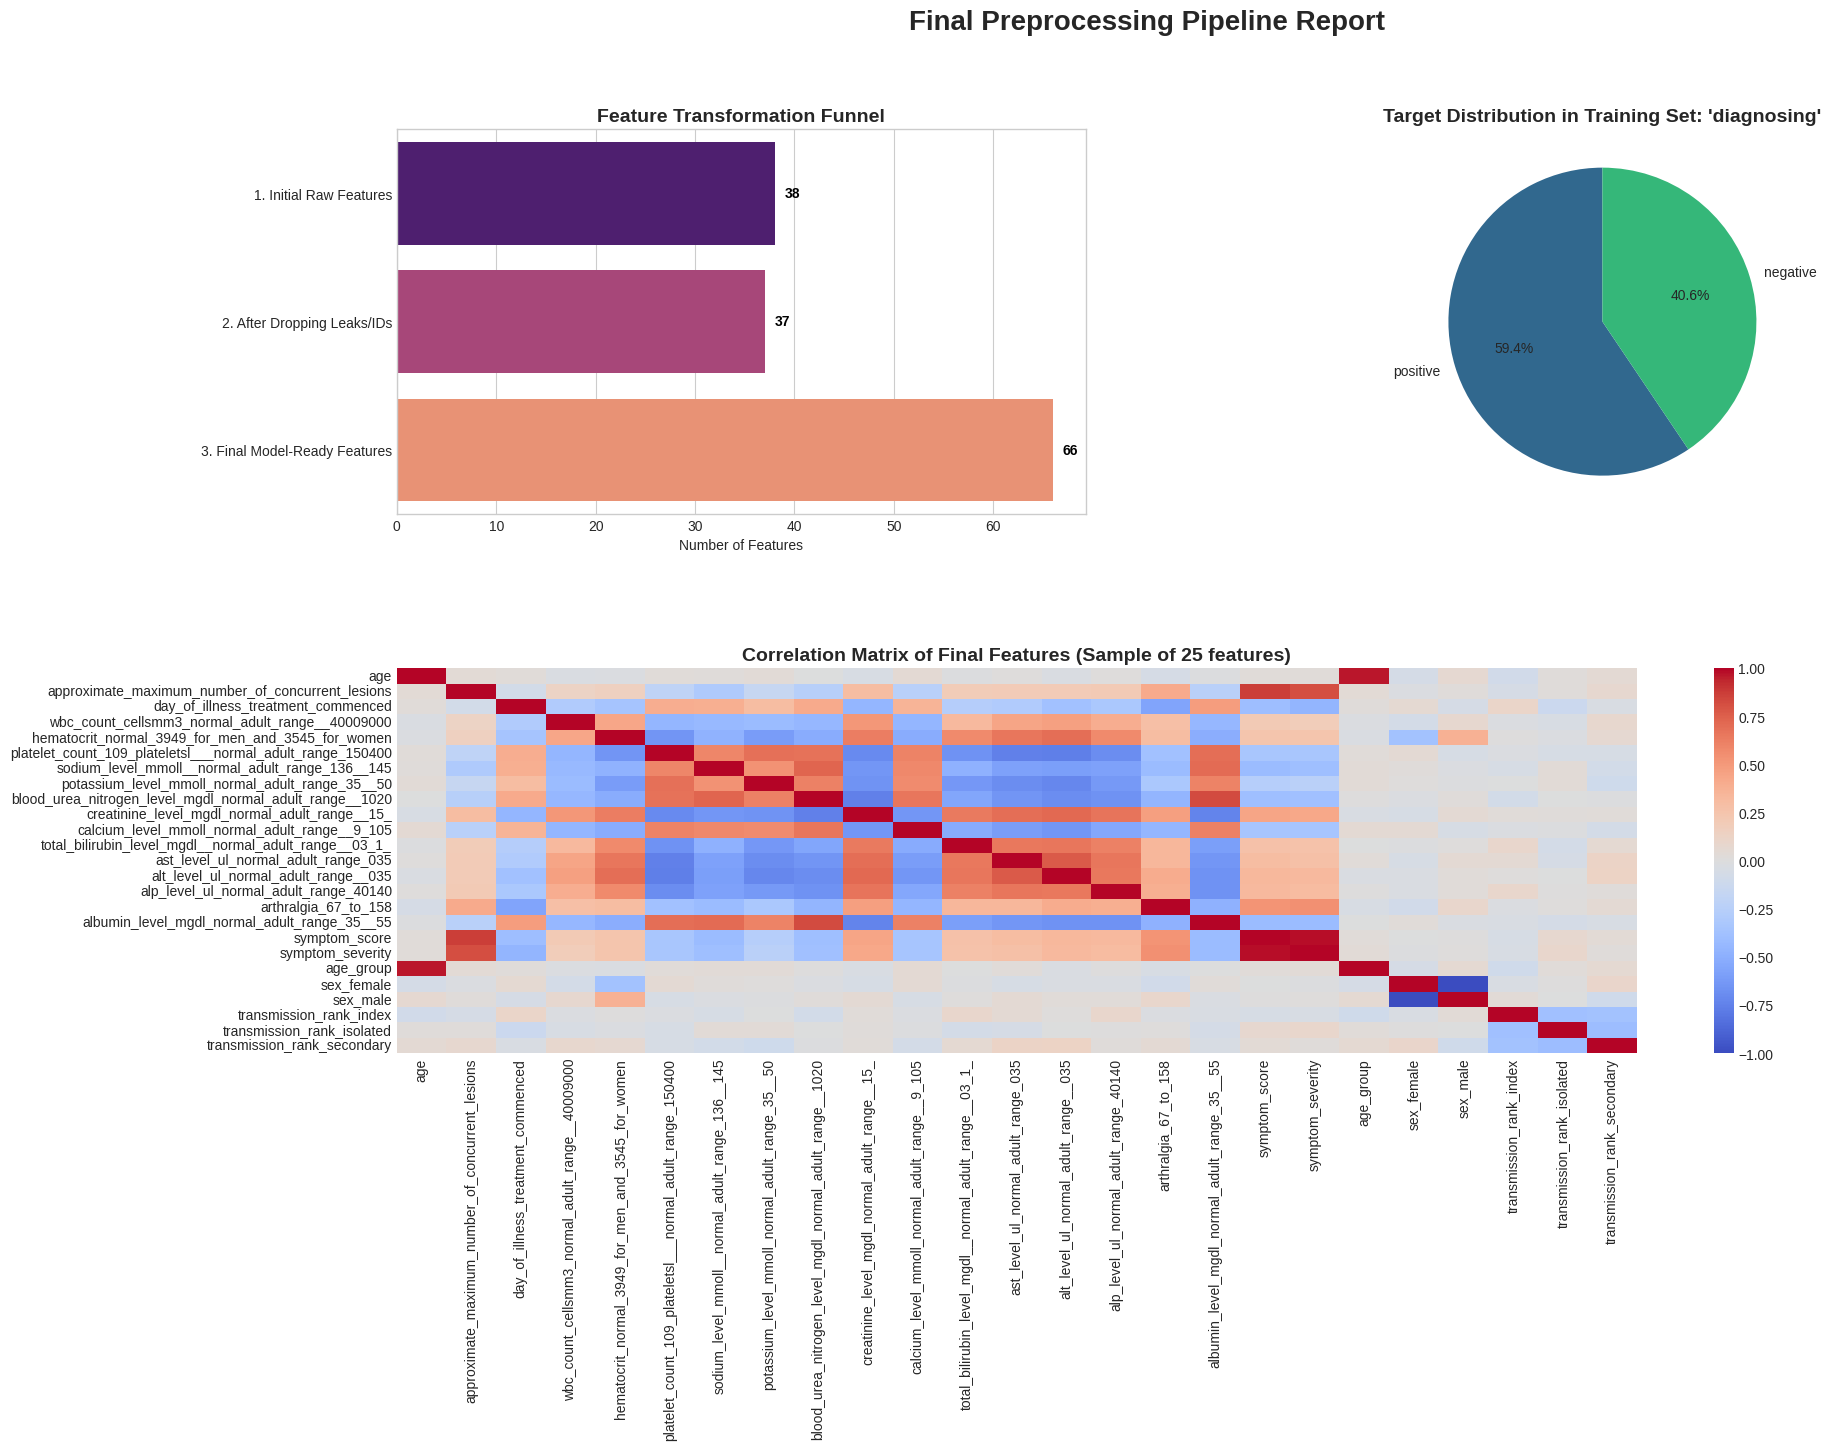


💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾
SAVING FINAL MODEL-READY DATASETS
💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾💾
✅ File 'X_train_final.csv' berhasil disimpan.
✅ File 'X_validation_final.csv' berhasil disimpan.
✅ File 'X_test_final.csv' berhasil disimpan.
✅ File 'y_train.csv' berhasil disimpan.
✅ File 'y_validation.csv' berhasil disimpan.
✅ File 'y_test.csv' berhasil disimpan.

🎉 Semua set data telah berhasil disimpan!
Anda sekarang bisa memuat file-file ini langsung untuk tahap modeling kapan pun.
🛑 Could not run Step 7 because the final data from previous steps was not found.


In [ ]:
# =============================================================================
# STEP 8: FINAL PREPROCESSING SUMMARY & PIPELINE REPORT
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

def generate_pipeline_report(df_original, X_initial, X_train_final, X_validation_final, X_test_final, y_train):
    """
    Creates a comprehensive summary report and visualization of the entire
    preprocessing pipeline, telling the story from raw to model-ready data.
    """
    print("\n" + "📜"*40)
    print("STEP 8: FINAL PREPROCESSING SUMMARY & PIPELINE REPORT")
    print("📜"*40)

    # --- 1. GATHER METRICS FROM THE ENTIRE PIPELINE ---
    initial_rows, initial_cols = df_original.shape
    X_initial_cols = len(X_initial.columns)
    final_cols = X_train_final.shape[1]

    # --- 2. DISPLAY FINAL SUMMARY TABLE ---
    print("📊 Pipeline Transformation Summary:")
    summary_data = {
        'Metric': [
            "1. Initial Features (Raw)",
            "2. Features after Dropping Leaks/IDs",
            "3. Final Model-Ready Features",
            "---",
            "Final Training Rows",
            "Final Validation Rows",
            "Final Testing Rows",
            "---",
            "Data is 100% Ready for Modeling"
        ],
        'Value': [
            initial_cols,
            X_initial_cols,
            final_cols,
            "---",
            len(X_train_final),
            len(X_validation_final),
            len(X_test_final),
            "---",
            "✅ Yes"
        ]
    }
    display(pd.DataFrame(summary_data))

    # --- 3. VISUALIZE THE PIPELINE JOURNEY ---
    print("\n" + "📈"*40)
    print("VISUALIZING THE PREPROCESSING PIPELINE JOURNEY")
    print("📈"*40)

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.4, wspace=0.25)
    fig.suptitle('Final Preprocessing Pipeline Report', fontsize=20, fontweight='bold')

    # Panel 1: The Feature Funnel (How feature count changed)
    ax1 = fig.add_subplot(gs[0, 0])
    funnel_stages = ['1. Initial Raw Features', '2. After Dropping Leaks/IDs', '3. Final Model-Ready Features']
    funnel_counts = [initial_cols, X_initial_cols, final_cols]
    sns.barplot(x=funnel_counts, y=funnel_stages, ax=ax1, palette='magma')
    ax1.set_title('Feature Transformation Funnel', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Features')
    for i, v in enumerate(funnel_counts):
        ax1.text(v + 1, i, str(v), color='black', va='center', fontweight='bold')

    # Panel 2: Target Variable Distribution (in the Training Set)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.set_title(f"Target Distribution in Training Set: '{y_train.name}'", fontsize=14, fontweight='bold')
    if y_train is not None and not y_train.empty:
        target_counts = y_train.value_counts()
        ax2.pie(target_counts.values, labels=target_counts.index, autopct='%1.1f%%',
                startangle=90, colors=sns.color_palette("viridis", len(target_counts)))
    else:
        ax2.text(0.5, 0.5, 'ERROR:\n`y_train` is empty or None.', ha='center', va='center', color='red')
        ax2.axis('off')

    # Panel 3: Correlation Heatmap of a sample of final features
    ax3 = fig.add_subplot(gs[1, :])
    sample_cols = X_train_final.columns[:min(25, len(X_train_final.columns))]
    corr_matrix = X_train_final[sample_cols].corr()
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', ax=ax3)
    ax3.set_title(f'Correlation Matrix of Final Features (Sample of {len(sample_cols)} features)', fontsize=14, fontweight='bold')
    ax3.tick_params(axis='x', rotation=90)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# =============================================================================
# EXECUTION FOR STEP 8
# =============================================================================

# This is the final step, run after all preprocessing is complete.
if 'X_train_final' in locals() and 'df_final_step2' in locals() and 'X_initial' in locals():
    print("\n" + "="*80)
    print("🚀 STARTING STEP 7: FINAL PREPROCESSING SUMMARY & PIPELINE REPORT")
    print("="*80)

    # Generate the report using all the necessary data pieces from our pipeline
    generate_pipeline_report(
        df_original=df_final_step2,
        X_initial=X_initial,
        X_train_final=X_train_final,
        X_validation_final=X_validation_final,
        X_test_final=X_test_final,
        y_train=y_train
    )

    # =============================================================================
# FINAL STEP: SAVING ALL PROCESSED DATASETS TO CSV FILES
# =============================================================================
import pandas as pd

print("\n" + "💾"*40)
print("SAVING FINAL MODEL-READY DATASETS")
print("💾"*40)

try:
    # Kumpulkan semua DataFrame dan Series yang akan disimpan dalam satu dictionary
    # Ini membuat proses penyimpanan lebih rapi dan mudah dikelola
    datasets_to_save = {
        'X_train_final.csv': X_train_final,
        'X_validation_final.csv': X_validation_final,
        'X_test_final.csv': X_test_final,
        'y_train.csv': y_train,
        'y_validation.csv': y_validation,
        'y_test.csv': y_test
    }

    # Loop untuk menyimpan setiap file
    for filename, data in datasets_to_save.items():
        # Menyimpan ke file CSV, index=False agar tidak ada kolom indeks tambahan
        data.to_csv(filename, index=False)
        print(f"✅ File '{filename}' berhasil disimpan.")

    print("\n🎉 Semua set data telah berhasil disimpan!")
    print("Anda sekarang bisa memuat file-file ini langsung untuk tahap modeling kapan pun.")

except NameError as e:
    print(f"🛑 GAGAL: Salah satu variabel data tidak ditemukan: {e}")
    print("   Pastikan seluruh pipeline preprocessing dari Step 1 hingga 6 sudah dijalankan dengan sukses.")

    # FINAL MESSAGE
    print("\n" + "🏁"*60)
    print("ENTIRE PREPROCESSING PIPELINE IS COMPLETE!")
    print("The following data is now ready for training your models:")
    print(f"   - `X_train_final`      (Shape: {X_train_final.shape})")
    print(f"   - `X_validation_final` (Shape: {X_validation_final.shape})")
    print(f"   - `X_test_final`       (Shape: {X_test_final.shape})")
    print(f"   - `y_train`            (Shape: {y_train.shape})")
    print(f"   - `y_validation`       (Shape: {y_validation.shape})")
    print(f"   - `y_test`             (Shape: {y_test.shape})")
    print("🏁"*60)

else:
    print("🛑 Could not run Step 7 because the final data from previous steps was not found.")

In [ ]:
# =============================================================================
# FASE 2: MODELING, FEATURE SELECTION, AND COMPARISON (VERSI FINAL & BENAR)
# =============================================================================

# =============================================================================
# LANGKAH 8: Latih dan Evaluasi Model Baseline
# =============================================================================
print("\n" + "🚀"*40); print("STEP 8: TRAINING BASELINE MODELS (ON ALL FEATURES)"); print("🚀"*40)
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
}
baseline_results = []
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name="", num_features=0):
    start_time = time.time(); model.fit(X_train, y_train); training_time = time.time() - start_time
    preds = model.predict(X_val)
    results = {
        "Model": model_name, "Accuracy": accuracy_score(y_val, preds), "Precision": precision_score(y_val, preds, zero_division=0),
        "Recall": recall_score(y_val, preds, zero_division=0), "F1-Score": f1_score(y_val, preds, zero_division=0),
        "Training Time (s)": training_time, "Num Features": num_features
    }
    print(f"✅ {model_name} Evaluated. Accuracy: {results['Accuracy']:.4f}, Time: {results['Training Time (s)']:.2f}s")
    return results
for name, model in models.items():
    baseline_results.append(evaluate_model(model, X_train_final, y_train_encoded, X_validation_final, y_validation_encoded, f"{name} (Baseline)", X_train_final.shape[1]))

# =============================================================================
# LANGKAH 9: Terapkan Seleksi Fitur IGWO (DENGAN FITNESS FUNCTION YANG BENAR)
# =============================================================================
print("\n" + "🧬"*40); print("STEP 9: APPLYING IGWO FEATURE SELECTION"); print("🧬"*40)

# FUNGSI FITNESS YANG BENAR: Melakukan validasi internal untuk skor yang jujur
def fitness_function(feature_mask, X, y, model):
    selected_indices = np.where(np.array(feature_mask) == 1)[0]
    if len(selected_indices) == 0: return 0.0
    X_subset = X.iloc[:, selected_indices]
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_subset, y, test_size=0.20, stratify=y, random_state=42)
    model.fit(X_train_sub, y_train_sub)
    accuracy = model.score(X_val_sub, y_val_sub)
    penalty = 0.01 * (len(selected_indices) / X.shape[1])
    return accuracy - penalty

class IGWOSelector:
    def __init__(self, fitness_func, num_wolves=20, max_iter=50):
        self.fitness_func = fitness_func; self.num_wolves = num_wolves; self.max_iter = max_iter
        self.eval_model = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
    def run(self, X_train, y_train):
        num_features = X_train.shape[1]
        wolves = [np.random.randint(0, 2, num_features) for _ in range(self.num_wolves)]
        fitness_scores = [self.fitness_func(w, X_train, y_train, self.eval_model) for w in wolves]
        for t in range(self.max_iter):
            sorted_wolves_fitness = sorted(zip(wolves, fitness_scores), key=lambda x: x[1], reverse=True)
            alpha_pos, beta_pos, delta_pos = np.array(sorted_wolves_fitness[0][0]), np.array(sorted_wolves_fitness[1][0]), np.array(sorted_wolves_fitness[2][0])
            a = 2 - t * (2 / self.max_iter)
            for i in range(self.num_wolves):
                wolf_np = np.array(wolves[i])
                r1,r2=np.random.rand(2); A1=2*a*r1-a; C1=2*r2; D_alpha=np.abs(C1*alpha_pos-wolf_np); X1=alpha_pos-A1*D_alpha
                r1,r2=np.random.rand(2); A2=2*a*r1-a; C2=2*r2; D_beta=np.abs(C2*beta_pos-wolf_np); X2=beta_pos-A2*D_beta
                r1,r2=np.random.rand(2); A3=2*a*r1-a; C3=2*r2; D_delta=np.abs(C3*delta_pos-wolf_np); X3=delta_pos-A3*D_delta
                wolves[i] = [1 if (X1[j]+X2[j]+X3[j])/3 > 0.5 else 0 for j in range(num_features)]
            fitness_scores = [self.fitness_func(w, X_train, y_train, self.eval_model) for w in wolves]
            if (t+1) % 5 == 0: print(f"   - Iteration {t+1}/{self.max_iter} | Best Fitness: {max(fitness_scores):.4f}")
        best_pos = wolves[np.argmax([self.fitness_func(w, X_train, y_train, self.eval_model) for w in wolves])]
        return X_train.columns[np.where(np.array(best_pos) == 1)[0]].tolist()

igwo_selector = IGWOSelector(fitness_function, num_wolves=10, max_iter=20)
best_features = igwo_selector.run(X_train_final, y_train_encoded)
print(f"\n✅ IGWO selected {len(best_features)} features.")
X_train_selected = X_train_final[best_features]
X_validation_selected = X_validation_final[best_features]
X_test_selected = X_test_final[best_features]

# =============================================================================
# LANGKAH 10: Latih Ulang Model & Bandingkan Hasil
# =============================================================================
print("\n" + "🏆"*40); print("STEP 10: RE-TRAINING & COMPARING RESULTS"); print("🏆"*40)
igwo_results = []
for name, model in models.items():
    igwo_results.append(evaluate_model(model, X_train_selected, y_train_encoded, X_validation_selected, y_validation_encoded, f"{name} (IGWO)", X_train_selected.shape[1]))

print("\n" + "📊"*40); print("FINAL RESULTS COMPARISON ON VALIDATION SET"); print("📊"*40)
final_comparison_df = pd.DataFrame(baseline_results + igwo_results)
display(final_comparison_df.style.format(precision=4).background_gradient(cmap='Greens', subset=['Accuracy', 'F1-Score']))

print("\n" + "🏅"*40); print("FINAL TEST ON UNSEEN DATA"); print("🏅"*40)
best_model_row = final_comparison_df.loc[final_comparison_df['F1-Score'].idxmax()]
best_model_name = best_model_row['Model']
print(f"🏆 Best performing model on validation set: {best_model_name}")
model_name_only = best_model_name.replace(" (Baseline)", "").replace(" (IGWO)", "")
final_model = models[model_name_only]
if "IGWO" in best_model_name: X_train_fit, X_test_eval = X_train_selected, X_test_selected
else: X_train_fit, X_test_eval = X_train_final, X_test_final
final_model.fit(X_train_fit, y_train_encoded)
final_preds = final_model.predict(X_test_eval)
print("\n--- Final Performance on Unseen Test Set ---"); print(classification_report(y_test_encoded, final_preds, zero_division=0))
print("\n" + "🏁"*60); print("MODELING & EXPERIMENTATION PHASE COMPLETE!"); print("🏁"*60)


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
STEP 8: TRAINING BASELINE MODELS (ON ALL FEATURES)
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
✅ Random Forest (Baseline) Evaluated. Accuracy: 1.0000, Time: 0.39s
✅ XGBoost (Baseline) Evaluated. Accuracy: 0.9867, Time: 1.29s
✅ CatBoost (Baseline) Evaluated. Accuracy: 1.0000, Time: 9.68s

🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬
STEP 9: APPLYING IGWO FEATURE SELECTION
🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬
   - Iteration 5/20 | Best Fitness: 0.9982
   - Iteration 10/20 | Best Fitness: 0.9982
   - Iteration 15/20 | Best Fitness: 0.9982
   - Iteration 20/20 | Best Fitness: 0.9982

✅ IGWO selected 12 features.

🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
STEP 10: RE-TRAINING & COMPARING RESULTS
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
✅ Random Forest (IGWO) Evaluated. Accuracy: 1.0000, Time: 0.16s
✅ XGBoost (IGWO) Evaluated. Accuracy: 1.0000, Time: 0.02s
✅ CatBoost (IGWO) Evaluated. Accuracy: 1.0000, Time: 1.30s

📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊

,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s),Num Features
0,Random Forest (Baseline),1.0000,1.0000,1.0000,1.0000,0.3869,66
1,XGBoost (Baseline),0.9867,1.0000,0.9773,0.9885,1.2930,66
2,CatBoost (Baseline),1.0000,1.0000,1.0000,1.0000,9.6781,66
3,Random Forest (IGWO),1.0000,1.0000,1.0000,1.0000,0.1598,12
4,XGBoost (IGWO),1.0000,1.0000,1.0000,1.0000,0.0211,12
5,CatBoost (IGWO),1.0000,1.0000,1.0000,1.0000,1.3005,12



🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅
FINAL TEST ON UNSEEN DATA
🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅
🏆 Best performing model on validation set: Random Forest (Baseline)

--- Final Performance on Unseen Test Set ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00        45

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75


🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
MODELING & EXPERIMENTATION PHASE COMPLETE!
🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁


In [19]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from IPython.display import display

# =============================================================================
# PASTIKAN VARIABEL INI SUDAH ADA DARI LANGKAH-LANGKAH SEBELUMNYA
# - X_train_final, X_validation_final
# - y_train_encoded, y_validation_encoded
# - positive_class_index (dari Step 7, LabelEncoder)
# =============================================================================

# --- 1. DEFINISI MODEL & FUNGSI EVALUASI ---
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
}

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, feature_scenario, num_features):
    """Fungsi terpusat untuk melatih dan mengevaluasi model."""
    print("-" * 50)
    print(f"Training Model: {model_name} ({feature_scenario})")

    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    preds = model.predict(X_val)

    results = {
        "Model": f"{model_name} ({feature_scenario})",
        "Accuracy": accuracy_score(y_val, preds),
        "Precision": precision_score(y_val, preds, pos_label=positive_class_index, zero_division=0),
        "Recall": recall_score(y_val, preds, pos_label=positive_class_index, zero_division=0),
        "F1-Score": f1_score(y_val, preds, pos_label=positive_class_index, zero_division=0),
        "Training Time (s)": training_time,
        "Num Features": num_features
    }

    print(f"✅ Evaluation Complete for {model_name}")
    print(f"   - Accuracy: {results['Accuracy']:.4f}")
    print(f"   - F1-Score: {results['F1-Score']:.4f}")
    return results

# =============================================================================
# LANGKAH 8: Latih dan Evaluasi Model Baseline (Menggunakan SEMUA Fitur)
# =============================================================================
print("\n" + "🚀"*40)
print("STEP 8: TRAINING BASELINE MODELS (ON ALL FEATURES)")
print("🚀"*40)
print("Starting training and evaluation process...\n")

all_results = []
for name, model in models.items():
    all_results.append(
        evaluate_model(model, X_train_final, y_train_encoded, X_validation_final, y_validation_encoded,
                       name, "Baseline", X_train_final.shape[1])
    )

# =============================================================================
# BAGIAN YANG DITAMBAHKAN UNTUK MENAMPILKAN TABEL HASIL AKHIR
# =============================================================================
print("\n" + "📊"*40)
print("BASELINE MODEL PERFORMANCE COMPARISON")
print("📊"*40)

# 1. Ubah list hasil menjadi DataFrame Pandas
results_df = pd.DataFrame(all_results)

# 2. Tampilkan DataFrame dengan gaya (styling) agar mudah dibaca
display(results_df.style.format(precision=4).background_gradient(cmap='viridis', subset=['Accuracy', 'F1-Score']))


🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
STEP 8: TRAINING BASELINE MODELS (ON ALL FEATURES)
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
Starting training and evaluation process...

--------------------------------------------------
Training Model: Random Forest (Baseline)
✅ Evaluation Complete for Random Forest
   - Accuracy: 1.0000
   - F1-Score: 1.0000
--------------------------------------------------
Training Model: XGBoost (Baseline)
✅ Evaluation Complete for XGBoost
   - Accuracy: 0.9867
   - F1-Score: 0.9885
--------------------------------------------------
Training Model: CatBoost (Baseline)
✅ Evaluation Complete for CatBoost
   - Accuracy: 1.0000
   - F1-Score: 1.0000

📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
BASELINE MODEL PERFORMANCE COMPARISON
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊


,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s),Num Features
0,Random Forest (Baseline),1.0000,1.0000,1.0000,1.0000,0.1908,66
1,XGBoost (Baseline),0.9867,1.0000,0.9773,0.9885,0.0552,66
2,CatBoost (Baseline),1.0000,1.0000,1.0000,1.0000,3.1817,66


In [20]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# =============================================================================
# LANGKAH 9: Terapkan Seleksi Fitur IGWO
# =============================================================================
print("\n" + "🧬"*40)
print("STEP 9: APPLYING IGWO FEATURE SELECTION")
print("🧬"*40)

def fitness_function(feature_mask, X, y, model):
    selected_indices = np.where(np.array(feature_mask) == 1)[0]
    if len(selected_indices) == 0: return 0.0
    X_subset = X.iloc[:, selected_indices]
    # Menggunakan porsi kecil data untuk evaluasi cepat di dalam fitness function
    X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X_subset, y, test_size=0.20, stratify=y, random_state=42)
    model.fit(X_train_sub, y_train_sub)
    accuracy = model.score(X_val_sub, y_val_sub)
    penalty = 0.01 * (len(selected_indices) / X.shape[1]) # Penalti untuk jumlah fitur
    return accuracy - penalty

class IGWOSelector:
    def __init__(self, fitness_func, num_wolves=20, max_iter=50):
        self.fitness_func = fitness_func
        self.num_wolves = num_wolves
        self.max_iter = max_iter
        # Menggunakan model yang ringan untuk evaluasi fitness yang cepat
        self.eval_model = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

    def run(self, X_train, y_train):
        num_features = X_train.shape[1]
        wolves = [np.random.randint(0, 2, num_features).tolist() for _ in range(self.num_wolves)]

        # Hitung fitness awal
        fitness_scores = [self.fitness_func(w, X_train, y_train, self.eval_model) for w in wolves]

        for t in range(self.max_iter):
            sorted_wolves_fitness = sorted(zip(wolves, fitness_scores), key=lambda x: x[1], reverse=True)
            alpha_pos, beta_pos, delta_pos = np.array(sorted_wolves_fitness[0][0]), np.array(sorted_wolves_fitness[1][0]), np.array(sorted_wolves_fitness[2][0])

            a = 2 - t * (2 / self.max_iter) # Parameter 'a' menurun seiring iterasi

            # Update posisi setiap 'wolf'
            for i in range(self.num_wolves):
                wolf_np = np.array(wolves[i])
                r1,r2=np.random.rand(2); A1=2*a*r1-a; C1=2*r2; D_alpha=np.abs(C1*alpha_pos-wolf_np); X1=alpha_pos-A1*D_alpha
                r1,r2=np.random.rand(2); A2=2*a*r1-a; C2=2*r2; D_beta=np.abs(C2*beta_pos-wolf_np); X2=beta_pos-A2*D_beta
                r1,r2=np.random.rand(2); A3=2*a*r1-a; C3=2*r2; D_delta=np.abs(C3*delta_pos-wolf_np); X3=delta_pos-A3*D_delta

                # Posisi baru diubah menjadi biner (0 atau 1)
                wolves[i] = [1 if (X1[j]+X2[j]+X3[j])/3 > 0.5 else 0 for j in range(num_features)]

            # Hitung ulang fitness setelah update posisi
            fitness_scores = [self.fitness_func(w, X_train, y_train, self.eval_model) for w in wolves]

            # Cetak progres setiap 5 iterasi
            if (t+1) % 5 == 0:
                print(f"  - Iteration {t+1}/{self.max_iter} | Best Fitness: {max(fitness_scores):.4f}")

        # Cari posisi terbaik setelah semua iterasi selesai
        best_pos = wolves[np.argmax(fitness_scores)]
        return X_train.columns[np.where(np.array(best_pos) == 1)[0]].tolist()

# Jalankan IGWO
igwo_selector = IGWOSelector(fitness_function, num_wolves=10, max_iter=20)
best_features = igwo_selector.run(X_train_final, y_train_encoded)

print(f"\n✅ IGWO selected {len(best_features)} features.")
print("\nSelected features list:")
print(best_features)

# Siapkan data dengan fitur terpilih untuk langkah selanjutnya
X_train_selected = X_train_final[best_features]
X_validation_selected = X_validation_final[best_features]
X_test_selected = X_test_final[best_features]


🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬
STEP 9: APPLYING IGWO FEATURE SELECTION
🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬🧬
  - Iteration 5/20 | Best Fitness: 0.9997
  - Iteration 10/20 | Best Fitness: 0.9997
  - Iteration 15/20 | Best Fitness: 0.9997
  - Iteration 20/20 | Best Fitness: 0.9997

✅ IGWO selected 2 features.

Selected features list:
['dysuria_no', 'conjunctivitis_yes']


In [21]:
# =============================================================================
# LANGKAH 10: Latih Ulang Model pada Fitur Terpilih & Bandingkan Hasil
# =============================================================================
print("\n" + "🏆"*40); print("STEP 10: RE-TRAINING ON SELECTED FEATURES & COMPARING RESULTS"); print("🏆"*40)

for name, model in models.items():
    all_results.append(
        evaluate_model(model, X_train_selected, y_train_encoded, X_validation_selected, y_validation_encoded,
                       name, "IGWO", X_train_selected.shape[1])
    )

# Tampilkan tabel perbandingan akhir
final_comparison_df = pd.DataFrame(all_results)
display(final_comparison_df.sort_values(by="F1-Score", ascending=False).style.format(precision=4).background_gradient(cmap='Greens', subset=['Accuracy', 'F1-Score']))



🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
STEP 10: RE-TRAINING ON SELECTED FEATURES & COMPARING RESULTS
🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆🏆
--------------------------------------------------
Training Model: Random Forest (IGWO)
✅ Evaluation Complete for Random Forest
   - Accuracy: 1.0000
   - F1-Score: 1.0000
--------------------------------------------------
Training Model: XGBoost (IGWO)
✅ Evaluation Complete for XGBoost
   - Accuracy: 1.0000
   - F1-Score: 1.0000
--------------------------------------------------
Training Model: CatBoost (IGWO)
✅ Evaluation Complete for CatBoost
   - Accuracy: 1.0000
   - F1-Score: 1.0000


,Model,Accuracy,Precision,Recall,F1-Score,Training Time (s),Num Features
0,Random Forest (Baseline),1.0000,1.0000,1.0000,1.0000,0.1908,66
2,CatBoost (Baseline),1.0000,1.0000,1.0000,1.0000,3.1817,66
4,XGBoost (IGWO),1.0000,1.0000,1.0000,1.0000,0.0172,2
3,Random Forest (IGWO),1.0000,1.0000,1.0000,1.0000,0.1553,2
5,CatBoost (IGWO),1.0000,1.0000,1.0000,1.0000,0.6596,2
1,XGBoost (Baseline),0.9867,1.0000,0.9773,0.9885,0.0552,66


In [22]:
# =============================================================================
# LANGKAH 11: UJI FINAL pada Data Tak Terlihat (Unseen Test Data)
# =============================================================================
print("\n" + "🏅"*40); print("STEP 11: FINAL TEST ON UNSEEN DATA"); print("🏅"*40)

# Cari model terbaik berdasarkan F1-Score di validation set
best_model_row = final_comparison_df.loc[final_comparison_df['F1-Score'].idxmax()]
best_model_full_name = best_model_row['Model']
print(f"🏆 Best performing model on validation set: {best_model_full_name}")

# Siapkan data yang benar untuk model terbaik (Baseline atau IGWO)
model_name_only = best_model_full_name.split(" (")[0]
final_model = models[model_name_only]

if "IGWO" in best_model_full_name:
    print("...using features selected by IGWO for the final test.")
    X_train_for_final_fit = X_train_selected
    X_test_for_final_eval = X_test_selected
else:
    print("...using all baseline features for the final test.")
    X_train_for_final_fit = X_train_final
    X_test_for_final_eval = X_test_final

# Latih ulang model terbaik pada gabungan data train + validation (opsional, tapi best practice)
# Untuk kesederhanaan, kita latih ulang hanya pada data training
final_model.fit(X_train_for_final_fit, y_train_encoded)
final_preds = final_model.predict(X_test_for_final_eval)

print("\n--- Final Performance on Unseen Test Set ---")
print(classification_report(y_test_encoded, final_preds, target_names=[str(c) for c in le.classes_], zero_division=0))
print("\n" + "🏁"*60); print("MODELING & EXPERIMENTATION PHASE COMPLETE!"); print("🏁"*60)



🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅
STEP 11: FINAL TEST ON UNSEEN DATA
🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅🏅
🏆 Best performing model on validation set: Random Forest (Baseline)
...using all baseline features for the final test.

--- Final Performance on Unseen Test Set ---
              precision    recall  f1-score   support

    negative       1.00      1.00      1.00        30
    positive       1.00      1.00      1.00        45

    accuracy                           1.00        75
   macro avg       1.00      1.00      1.00        75
weighted avg       1.00      1.00      1.00        75


🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
MODELING & EXPERIMENTATION PHASE COMPLETE!
🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁🏁
